In [7]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

from ipywidgets import IntProgress
from IPython.display import display, clear_output
import IPython

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [8]:
xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/home/andrei/code/andrei-ka/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [15]:
raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]

In [ ]:
for f_in in os.listdir(pickles_dir): 
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
    print(f_in)

In [42]:
##ok, it's ime to make X, y from a whole dataset...

drop_dups=True
drop_dups_str="_no_dups" if drop_dups else ""

sampling=50  #sampling rate
win_len=30   #wind size in secs

#overlap will add 2nd pass moving init windsow position...
#seems to add only 3% to prec/recall...

overlap=True 
overlap_len=(win_len-10)*sampling  #n secs overlap, dont make it neg !
                                  #here on overap pass we start nead the end of 1st frame
    
overlap_str="_with_overlap" if overlap else ""

feature_set="accel+gyro" # "accel" or "accel+gyro"

ignore_dudes = [ "Participant10" ]

adjusted=5
adjusted_str="_sensor_adjusted" if adjusted != 1 else ""
    
sensors=['Accelerometer_x_WD', 
         'Accelerometer_y_WD', 
         'Accelerometer_z_WD'] 

sensors_weights={ "Accelerometer_x_WD": 1.0 * adjusted, 
                  "Accelerometer_y_WD": 1.0 * adjusted, 
                  "Accelerometer_z_WD": 1.0 }
    
# our rgb-likes & sensor weights
if feature_set == "accel+gyro" :  
  sensors.extend(['Gyroscope_x_PD', 
                  'Gyroscope_y_PD', 
                  'Gyroscope_z_PD'])

  sensors_weights.update({ "Gyroscope_x_PD": 1.0, 
                           "Gyroscope_y_PD": 1.0, 
                           "Gyroscope_z_PD": 1.0 * adjusted})

if feature_set == "sigle" : 
    sensors=['Accelerometer_x_WD' ]
    sensors_weights={ "Accelerometer_x_WD": 1.0 * adjusted }
    
tot_frame_len=sampling*win_len
n_sensors=len(sensors)

#prefer to hardcode expected act_types here...

act_types=[ 'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' ]
n_act_types=len(act_types)
    
remap_acts=True
if remap_acts:
  act_types_maping={ 'drink' : [ 'DrinkSD', 'DrinkST' ],  
                     'smoke' : [ 'SmokeSD', 'SmokeST' ],  
                     'static': [ 'Sit',     'Stand'   ],
                     'eat'   : [ 'Eat'  ] 
                   }
  
id_str=str(len(sensors)) + "sensors_" + str(win_len) + "_win" + overlap_str+drop_dups_str+adjusted_str

skipping Participant10
Participant11_Data.pickle


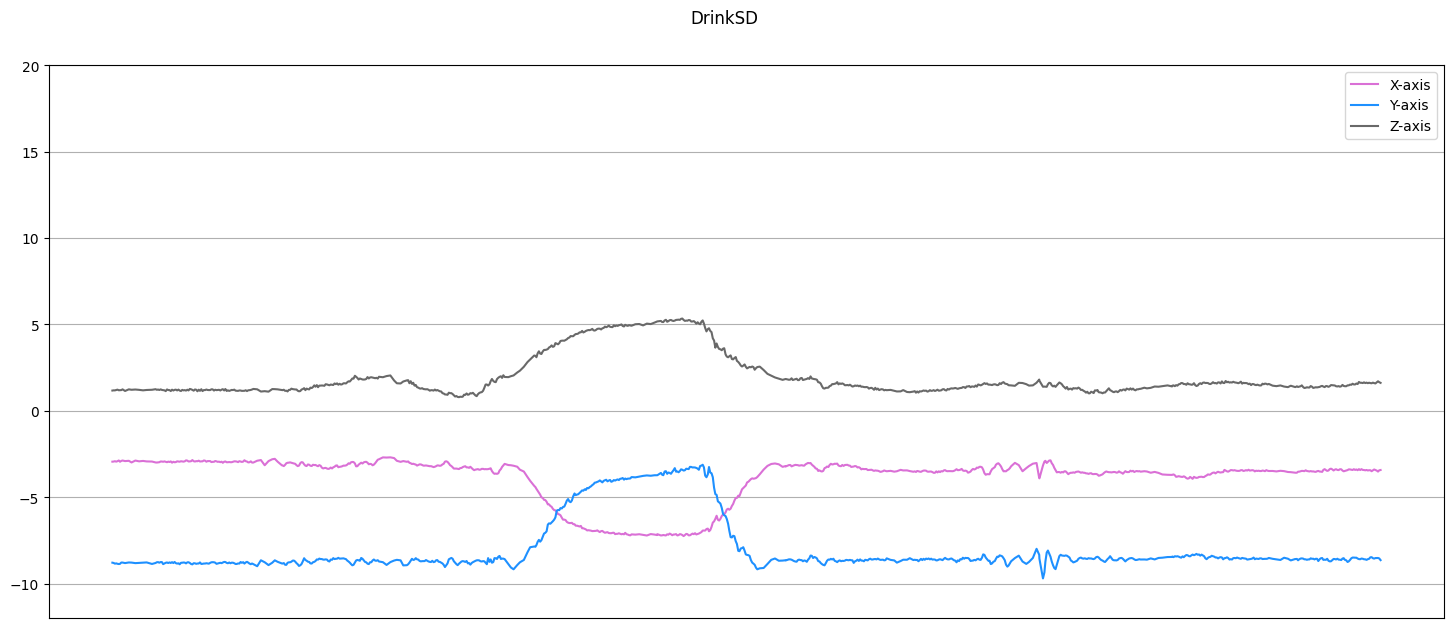

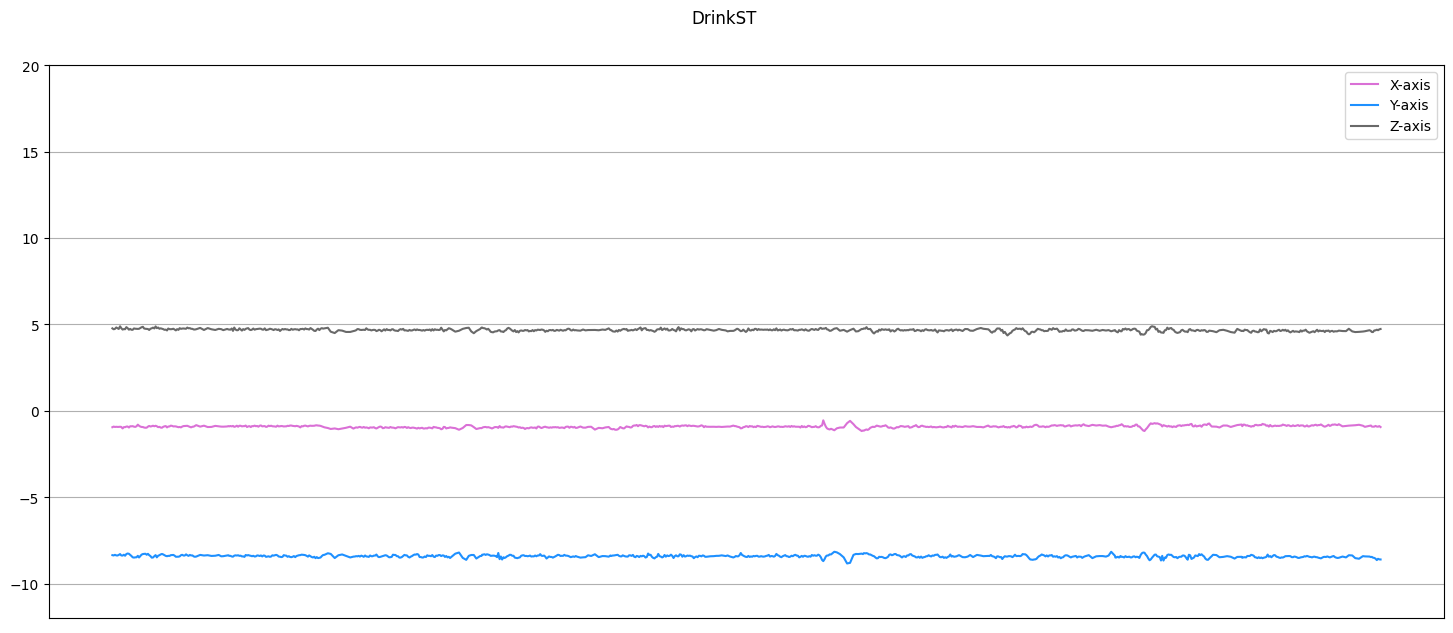

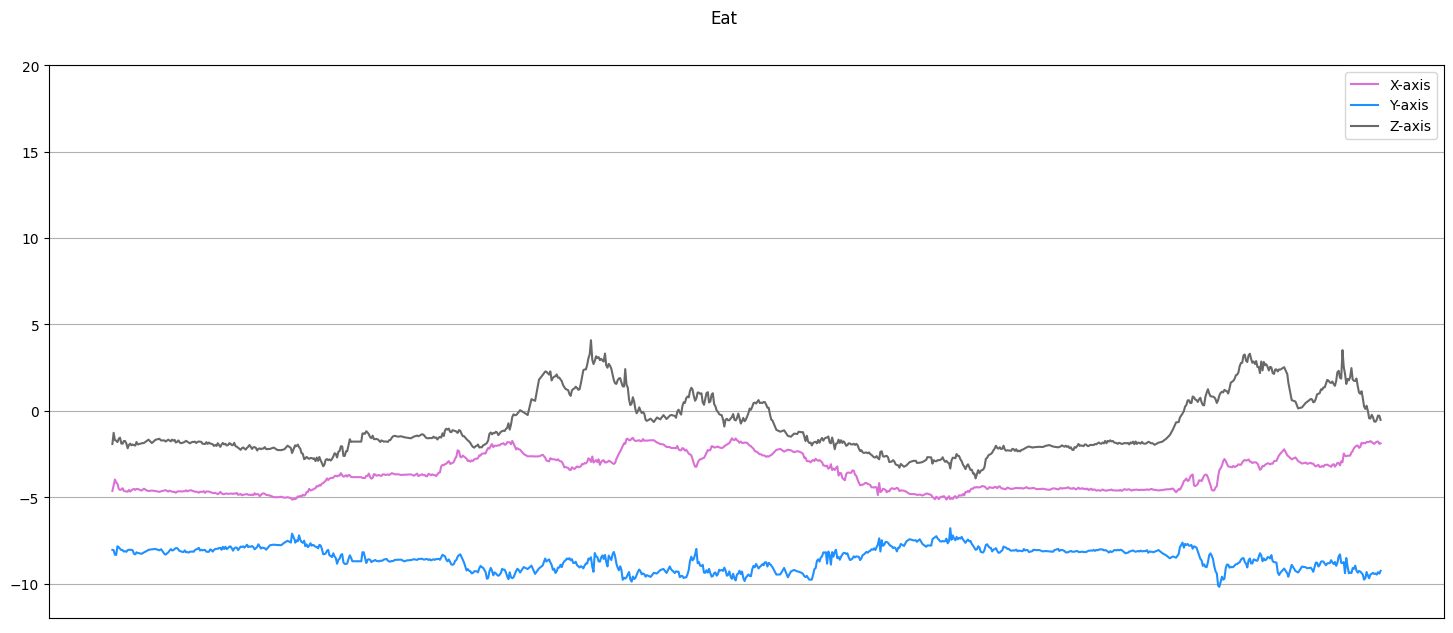

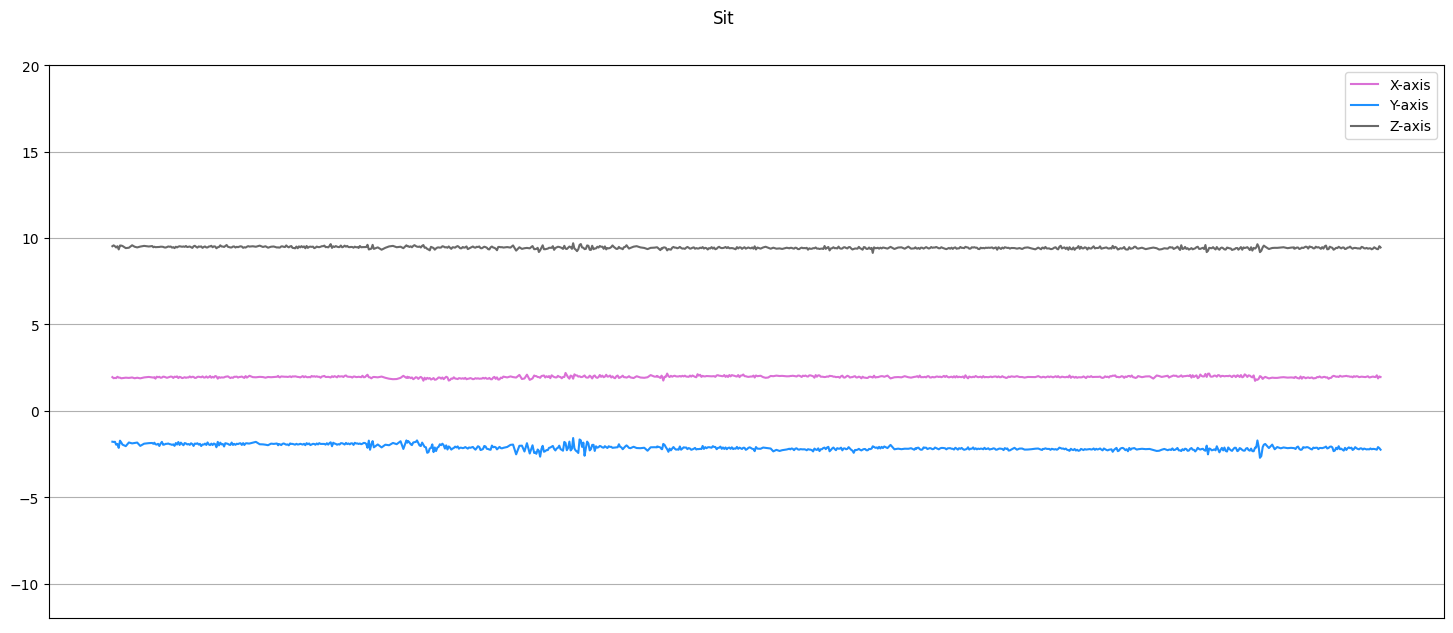

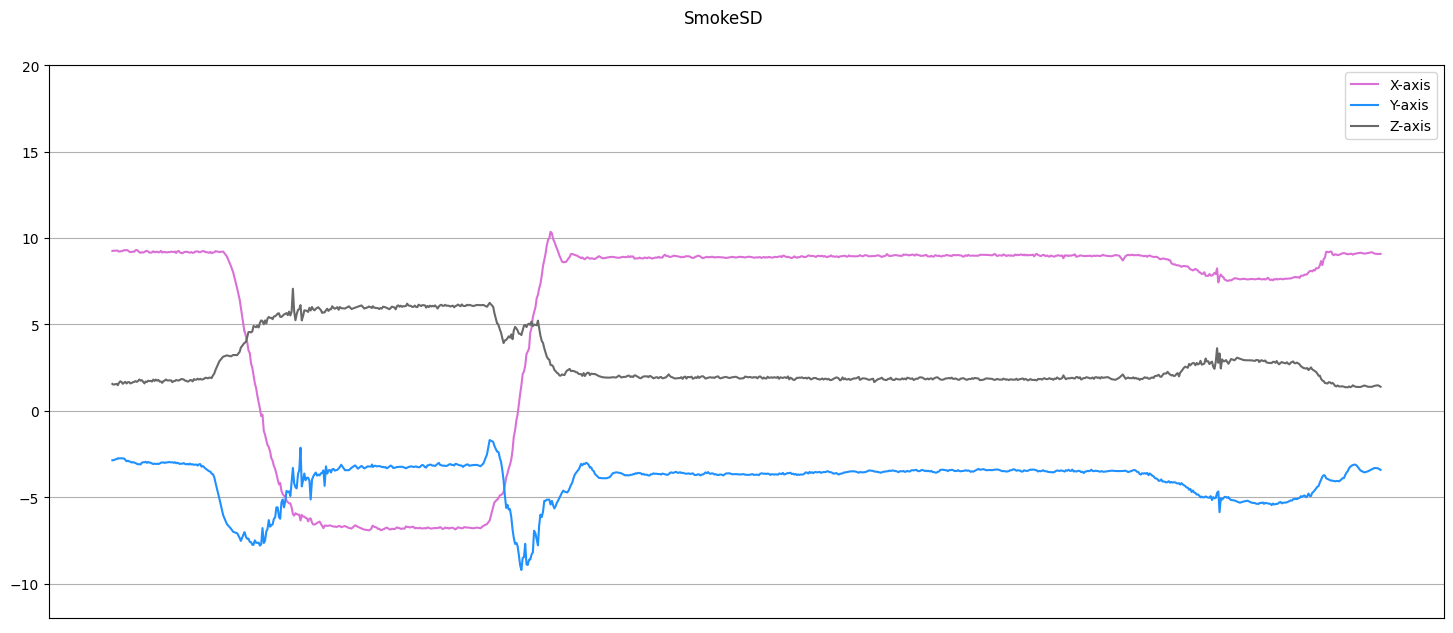

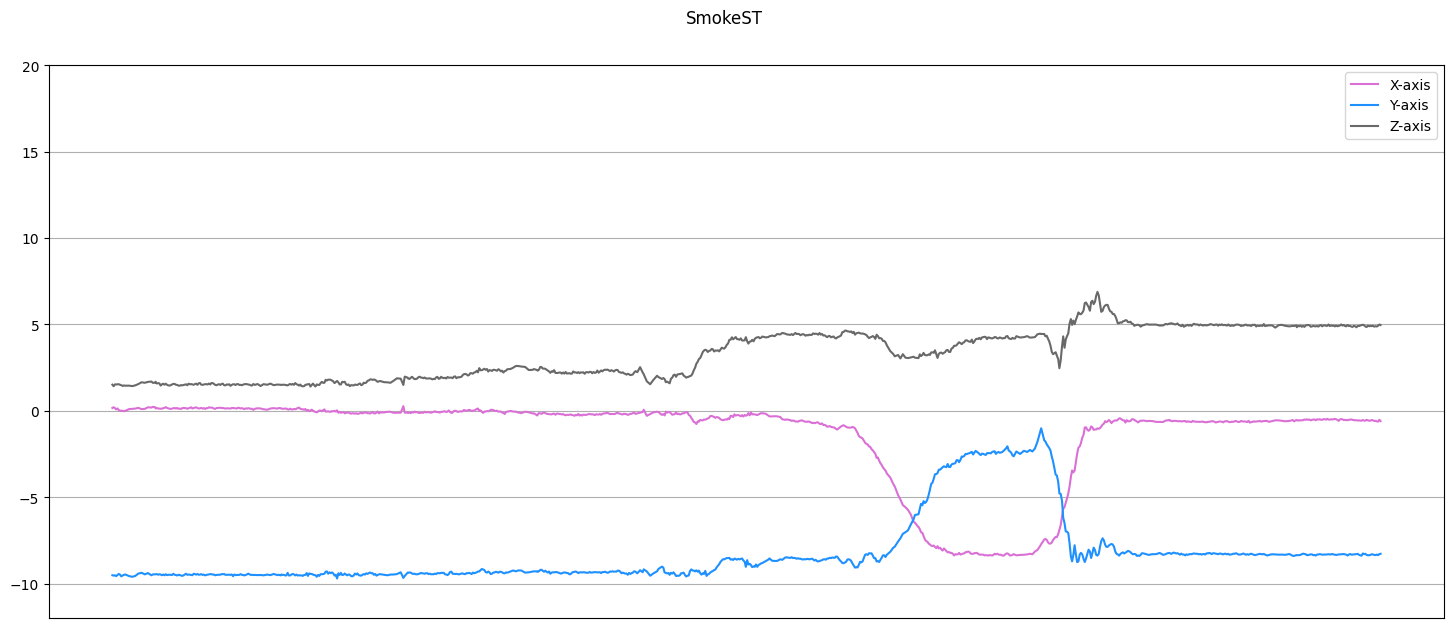

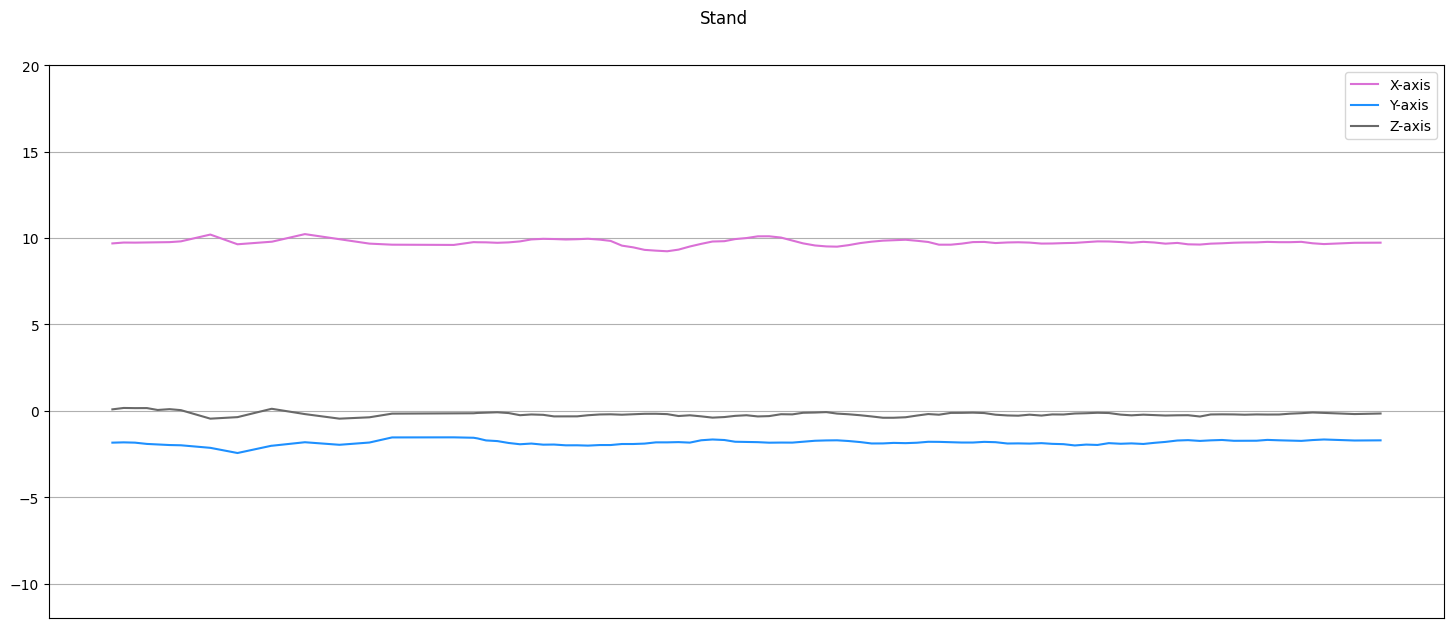

Participant1_Data.pickle


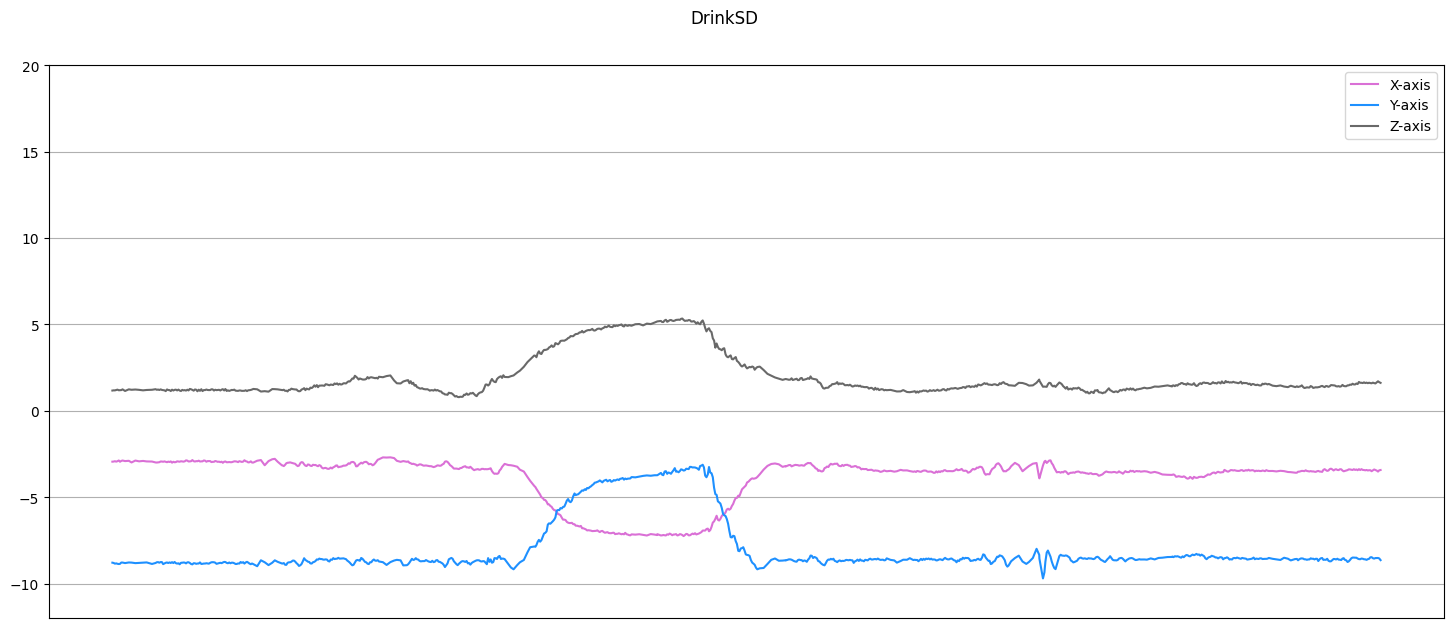

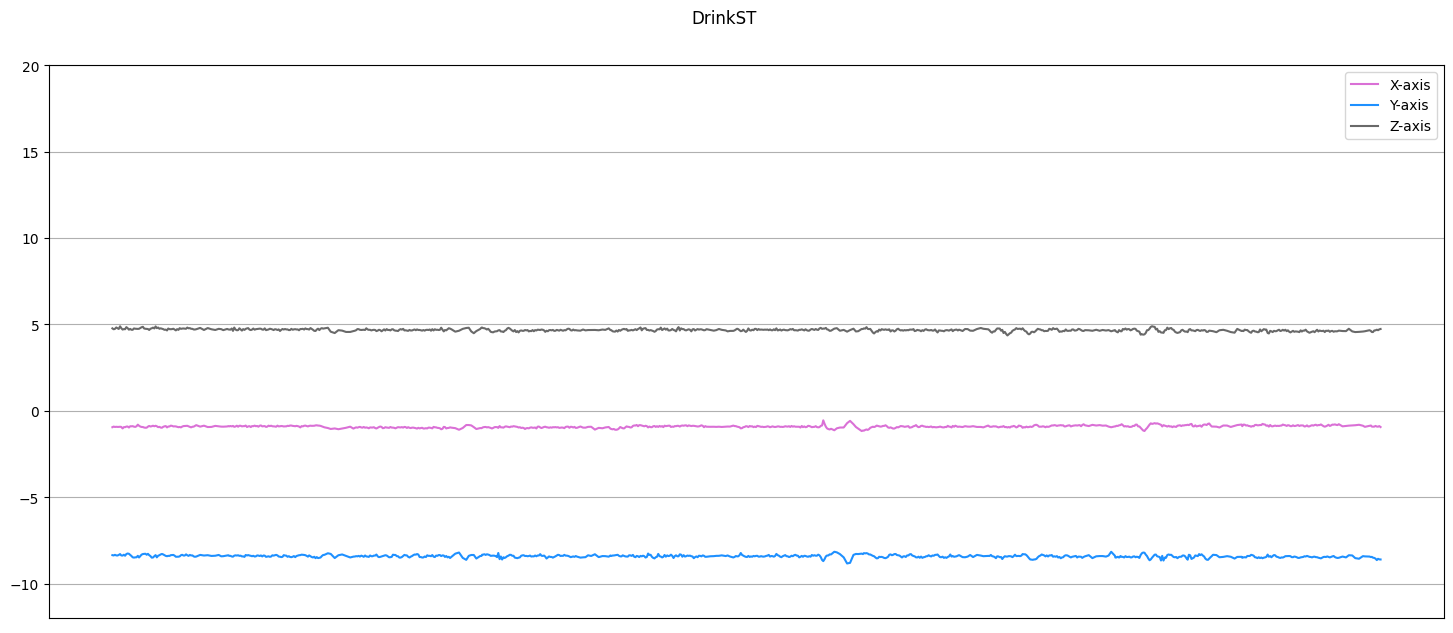

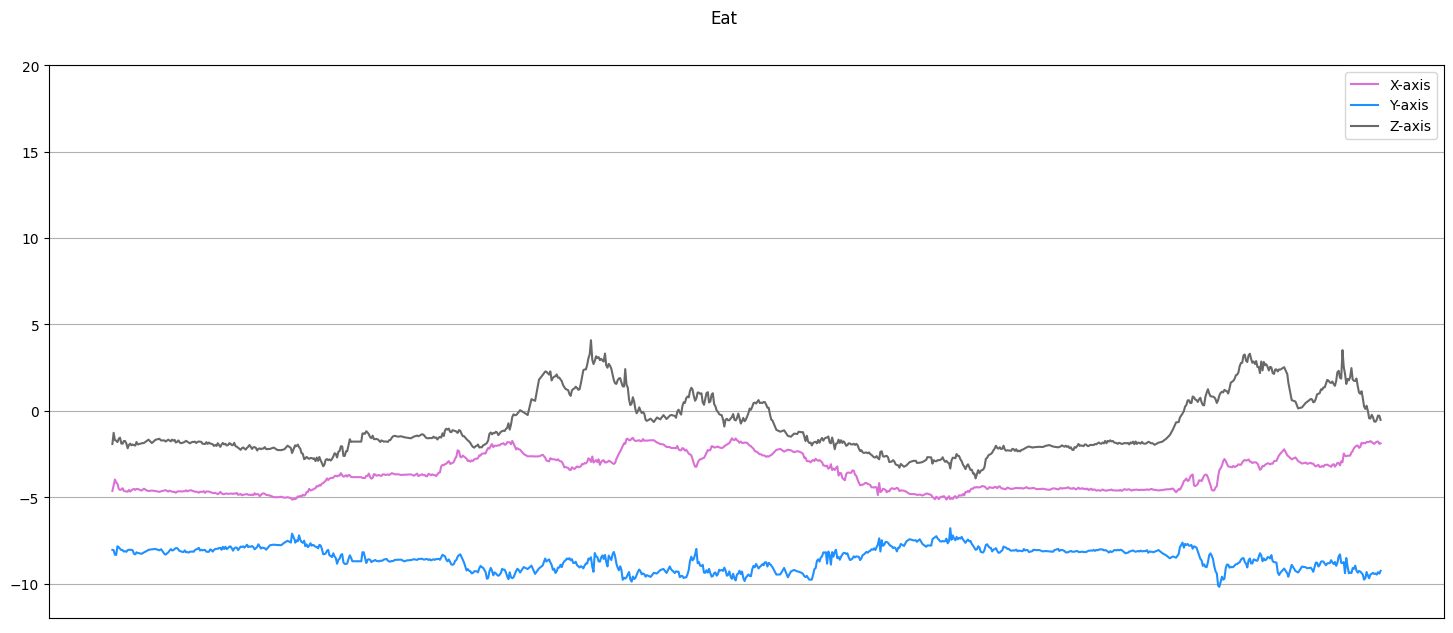

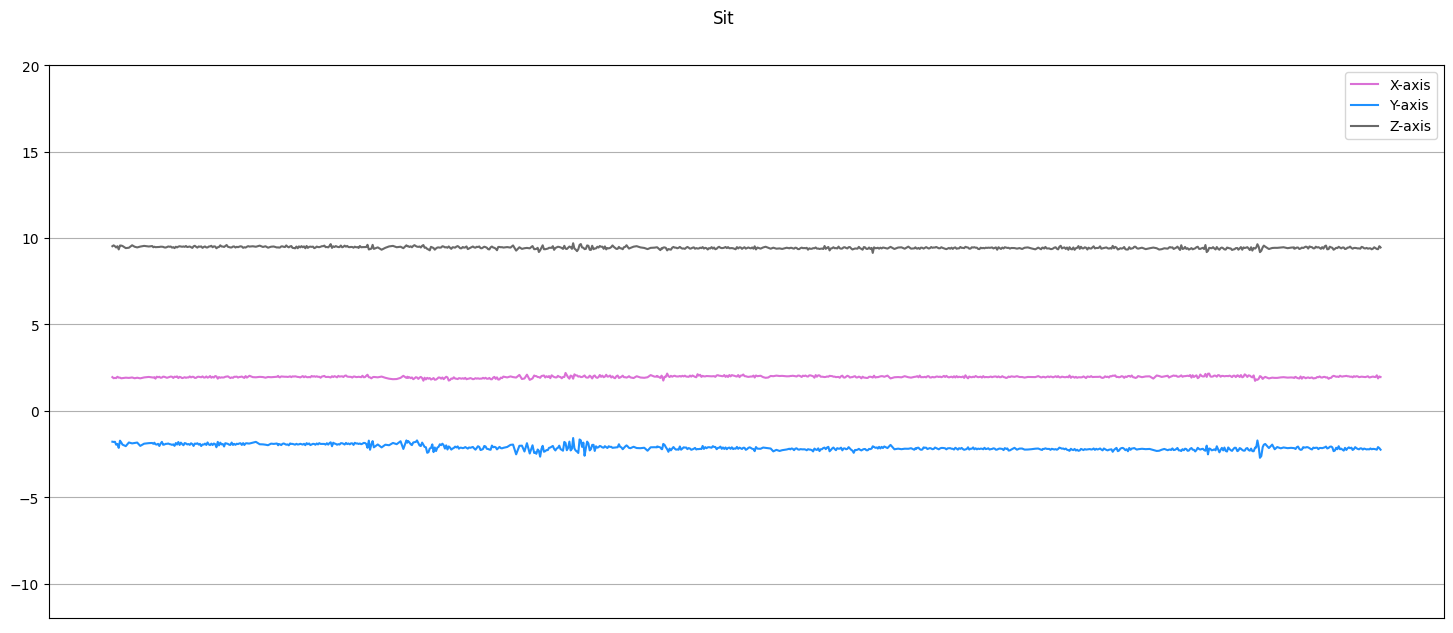

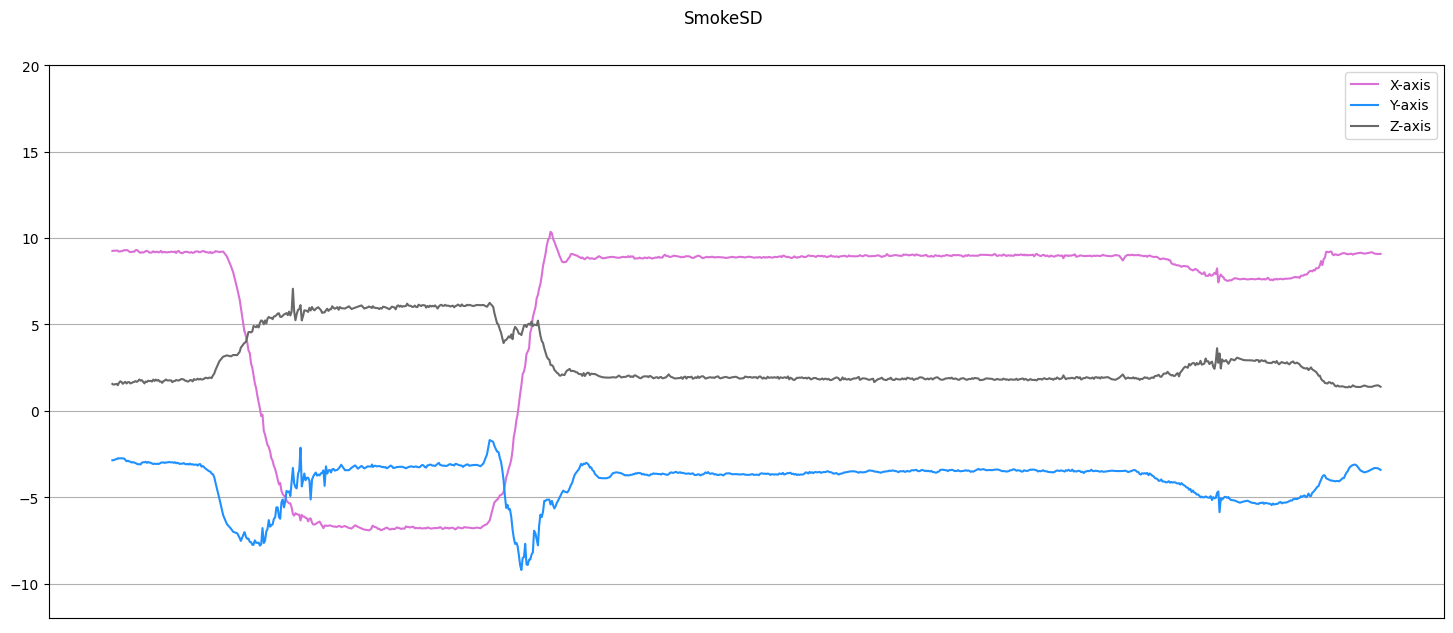

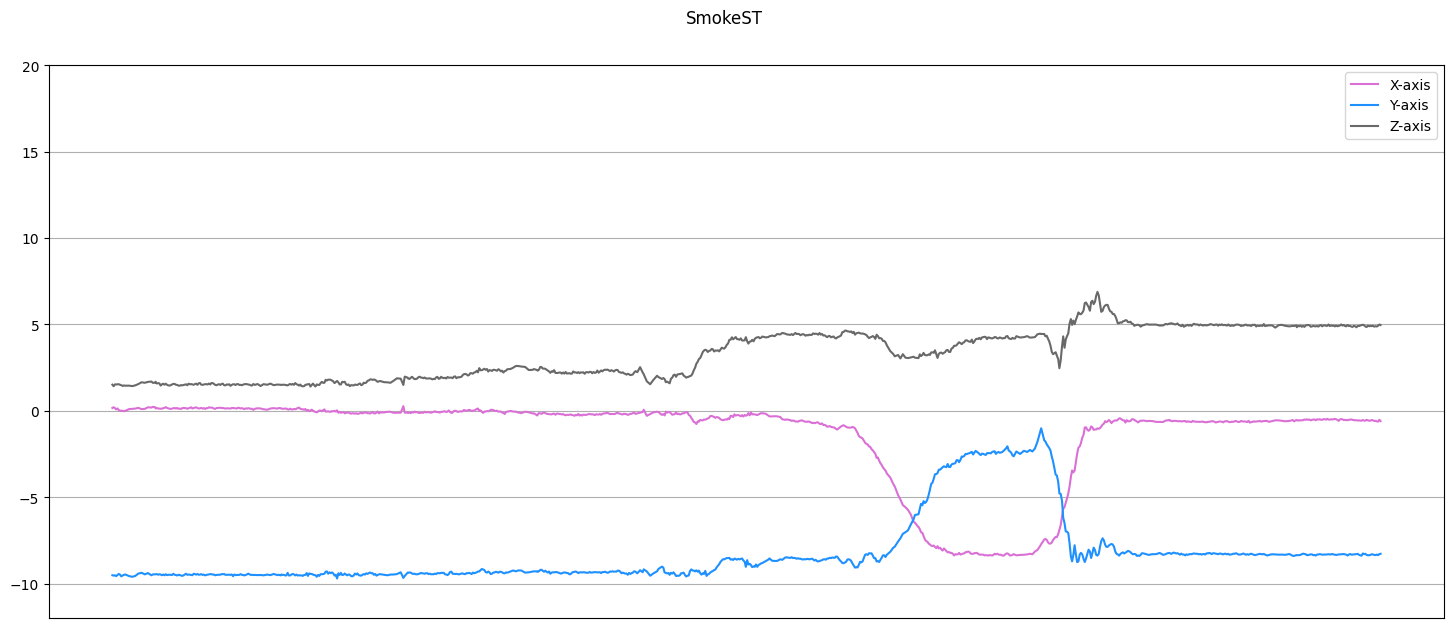

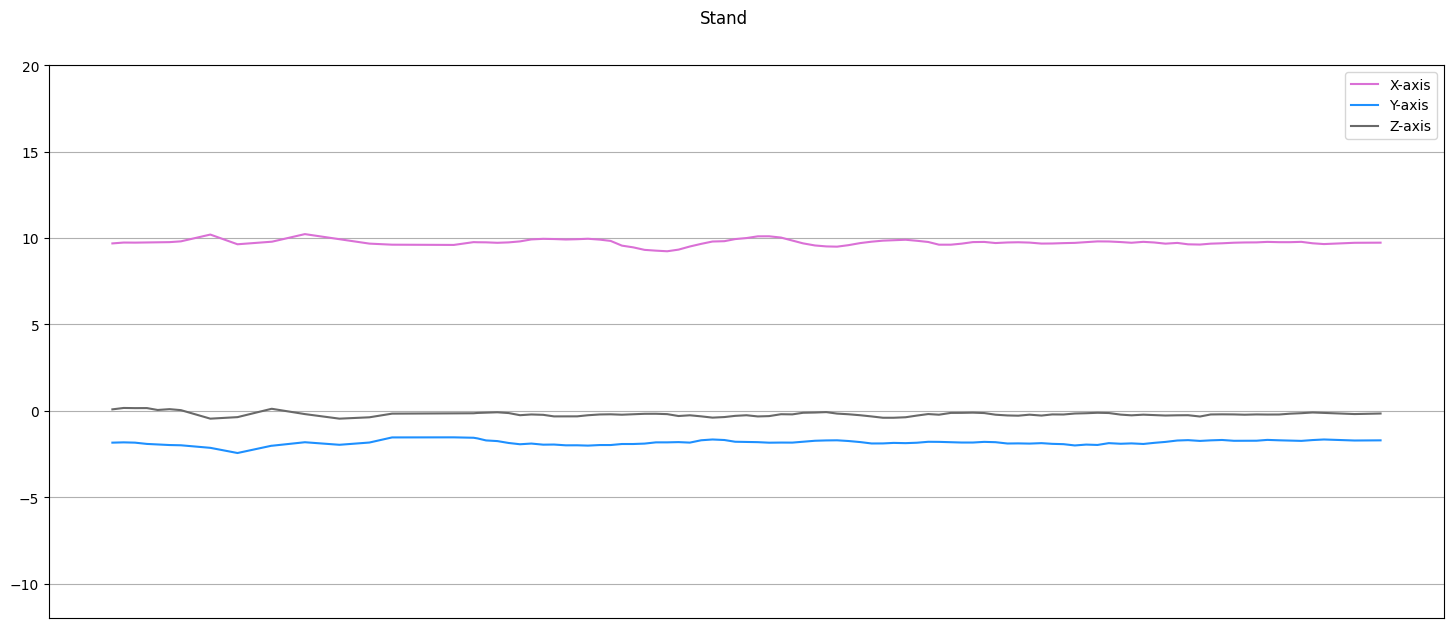

Participant2_Data.pickle


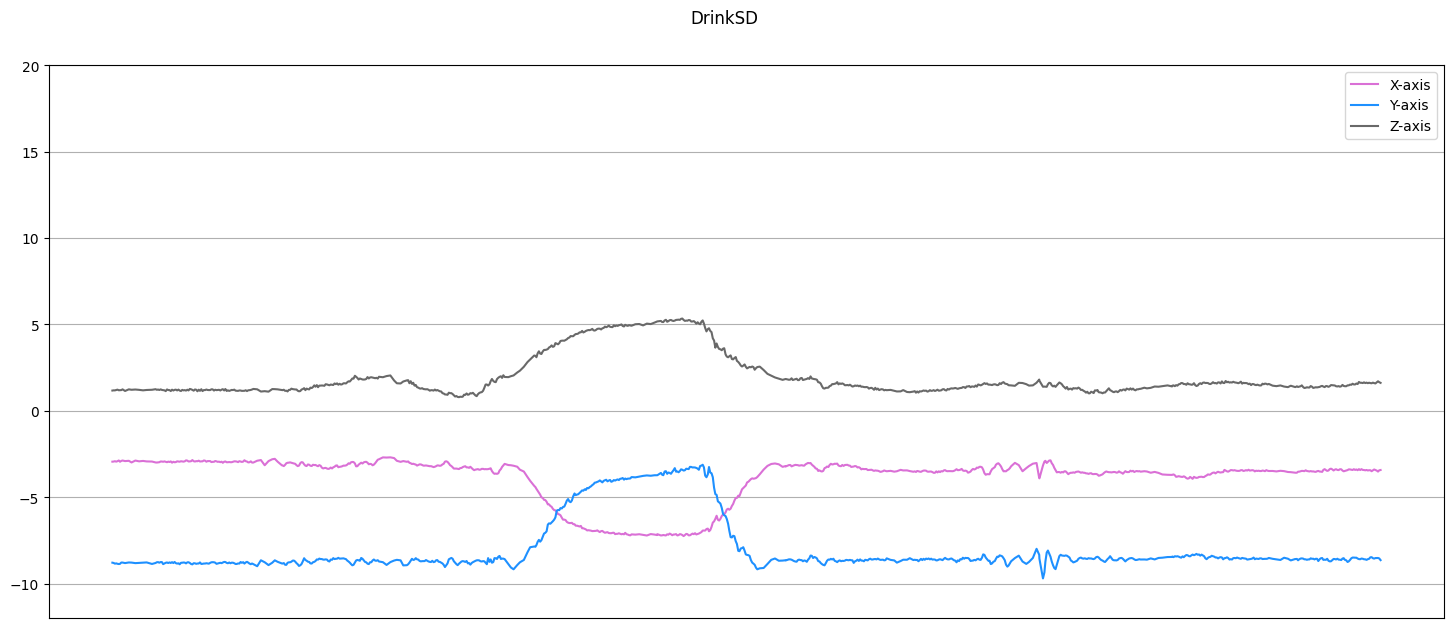

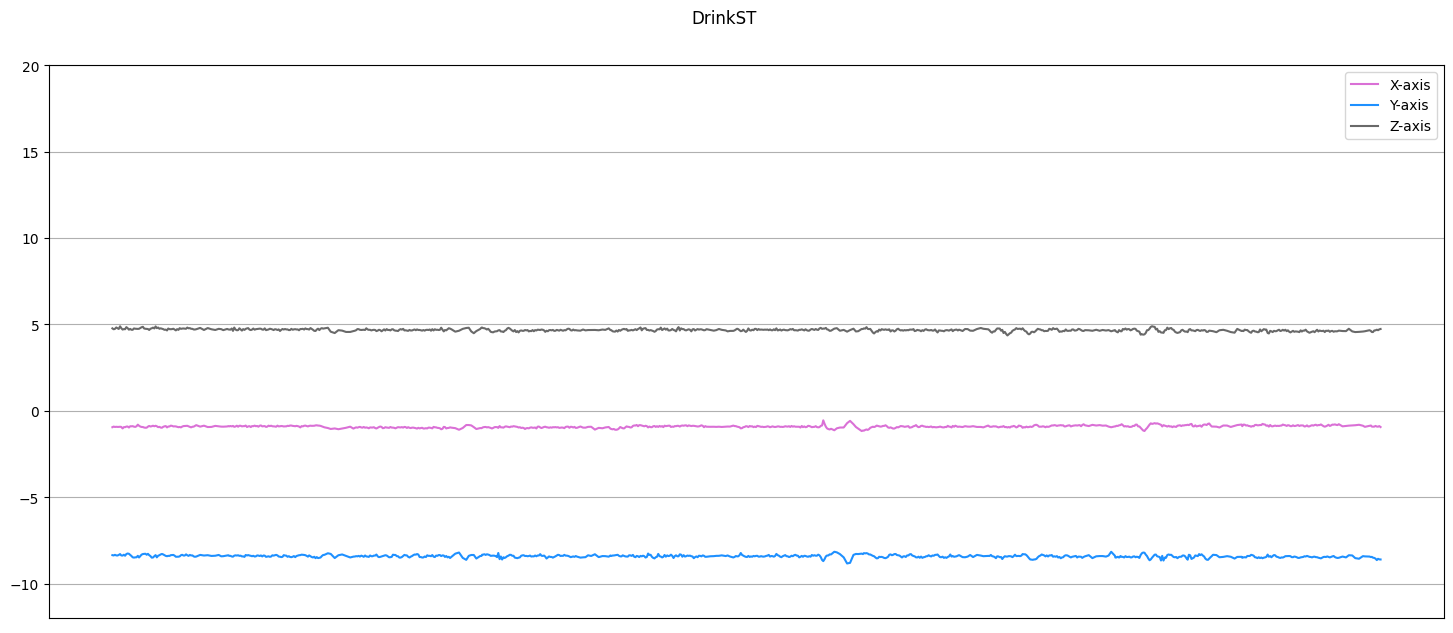

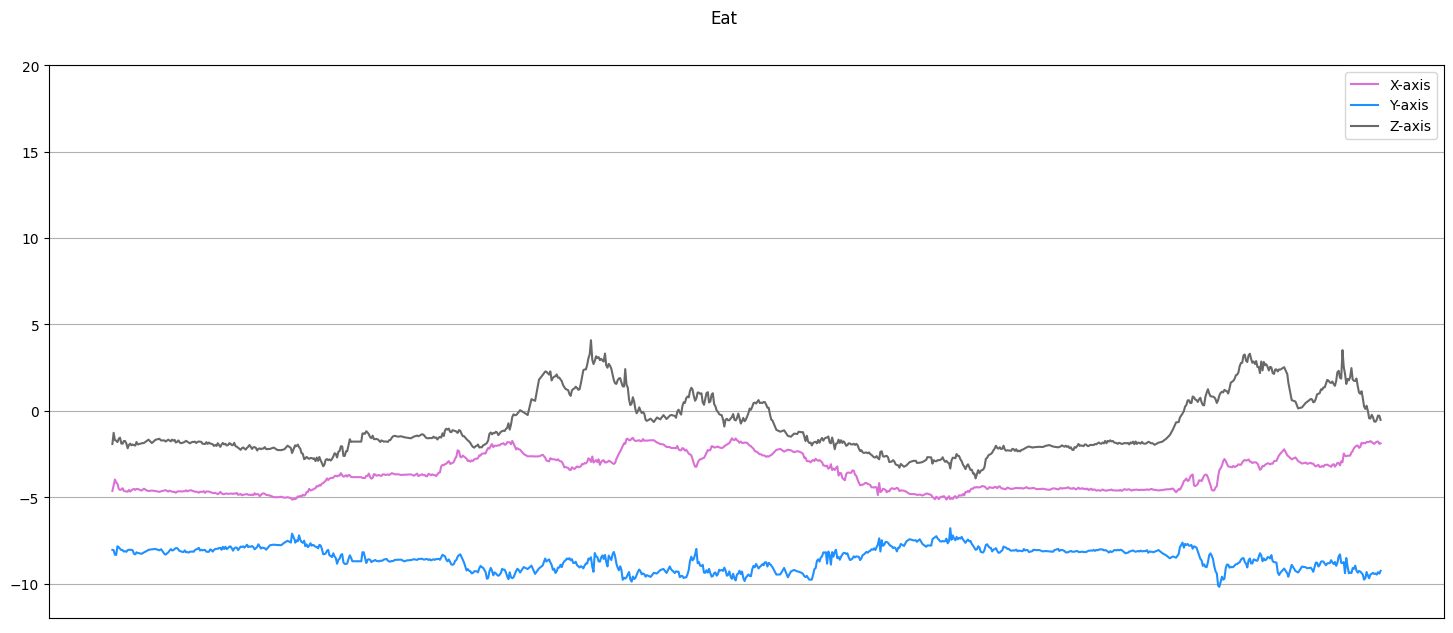

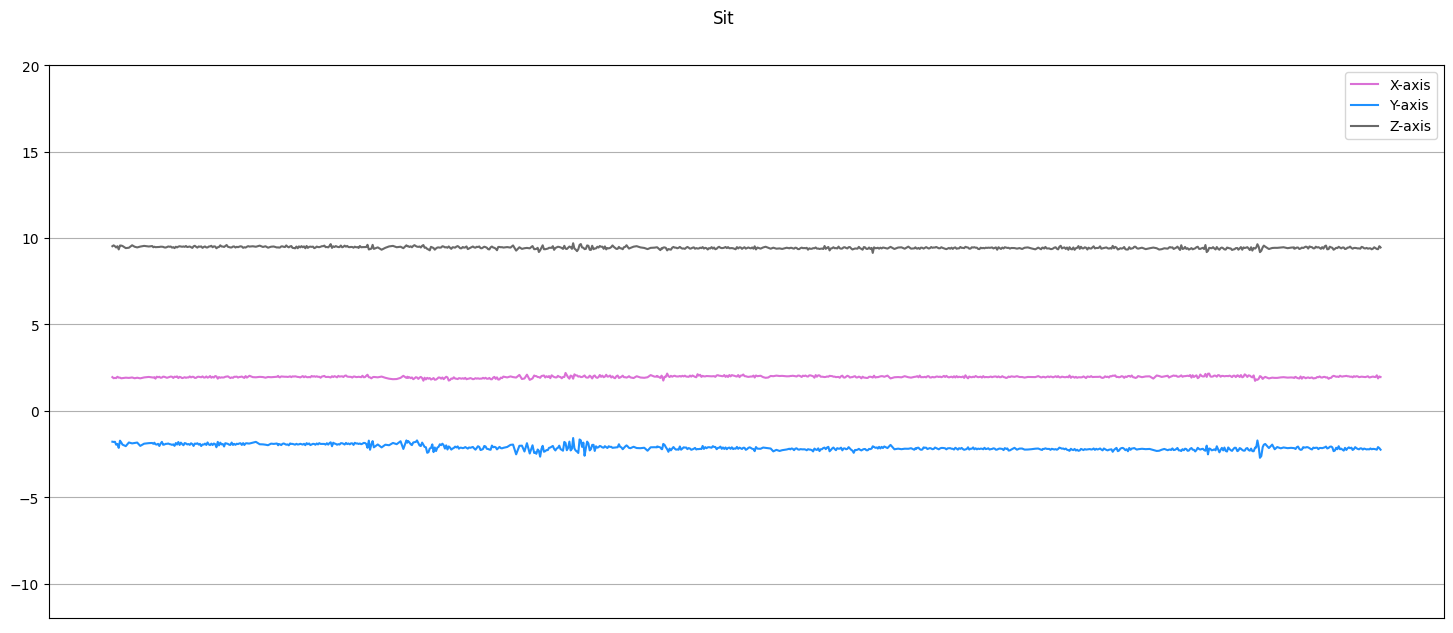

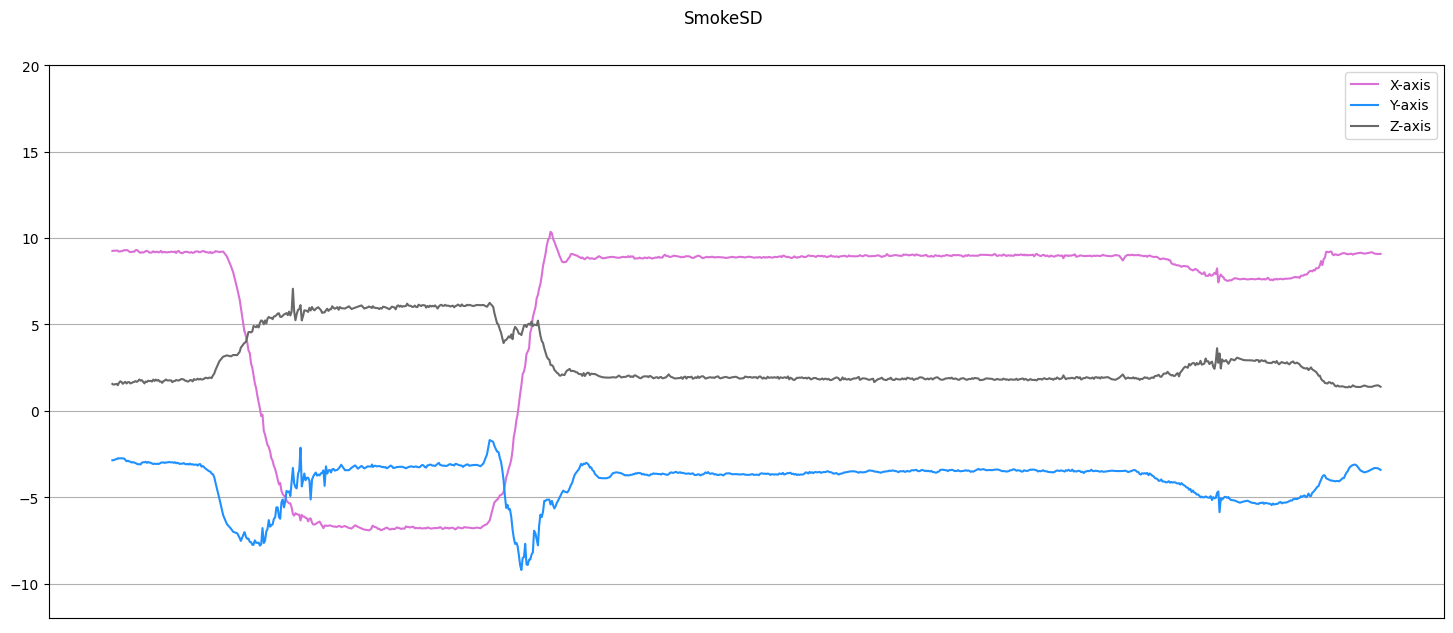

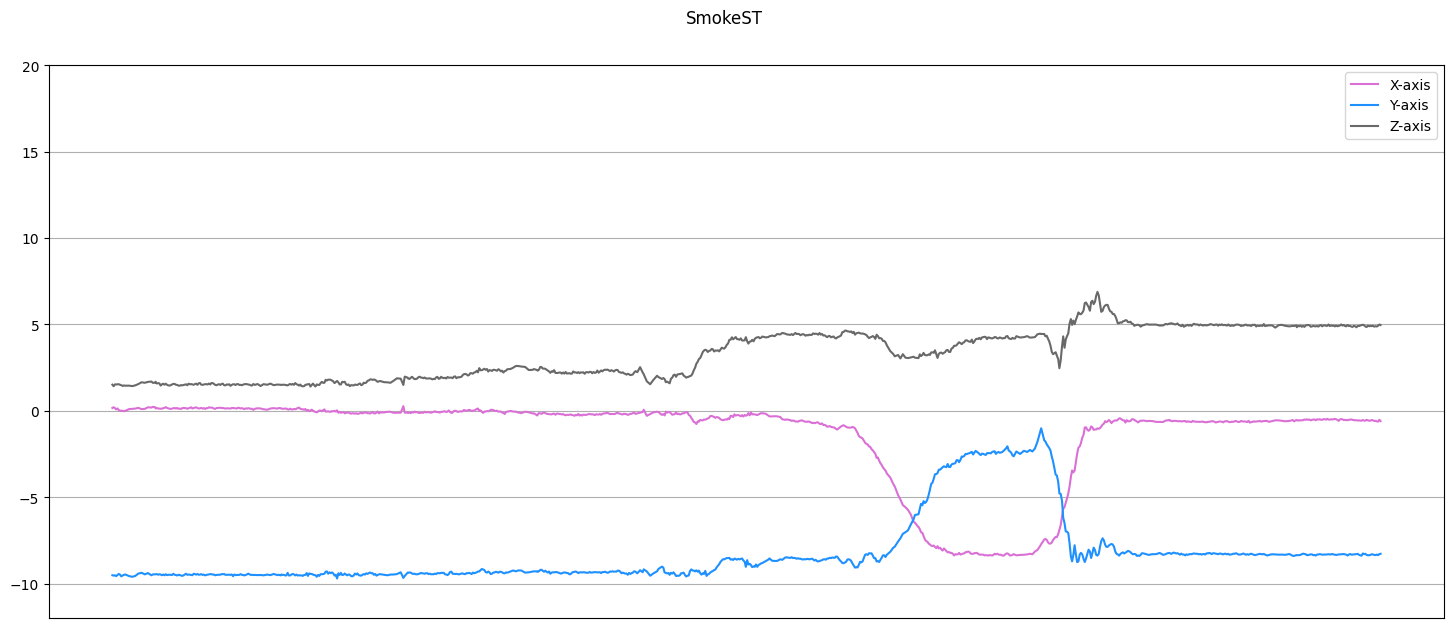

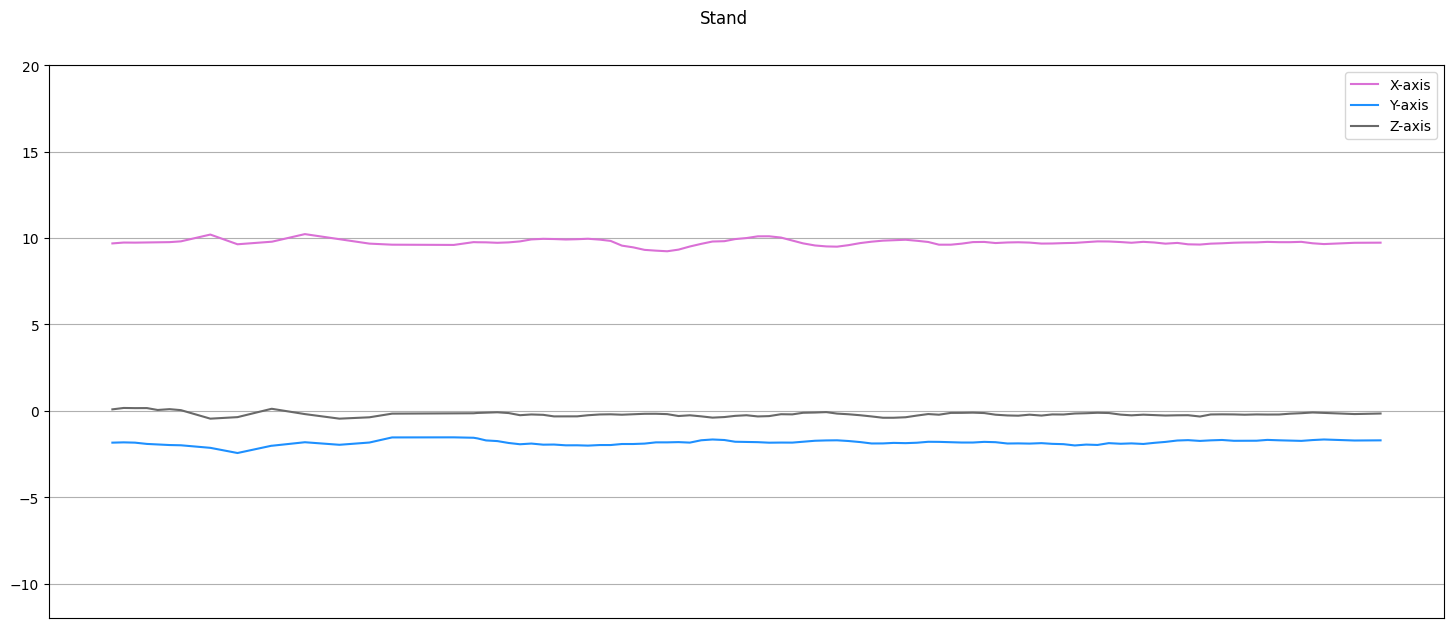

Participant3_Data.pickle


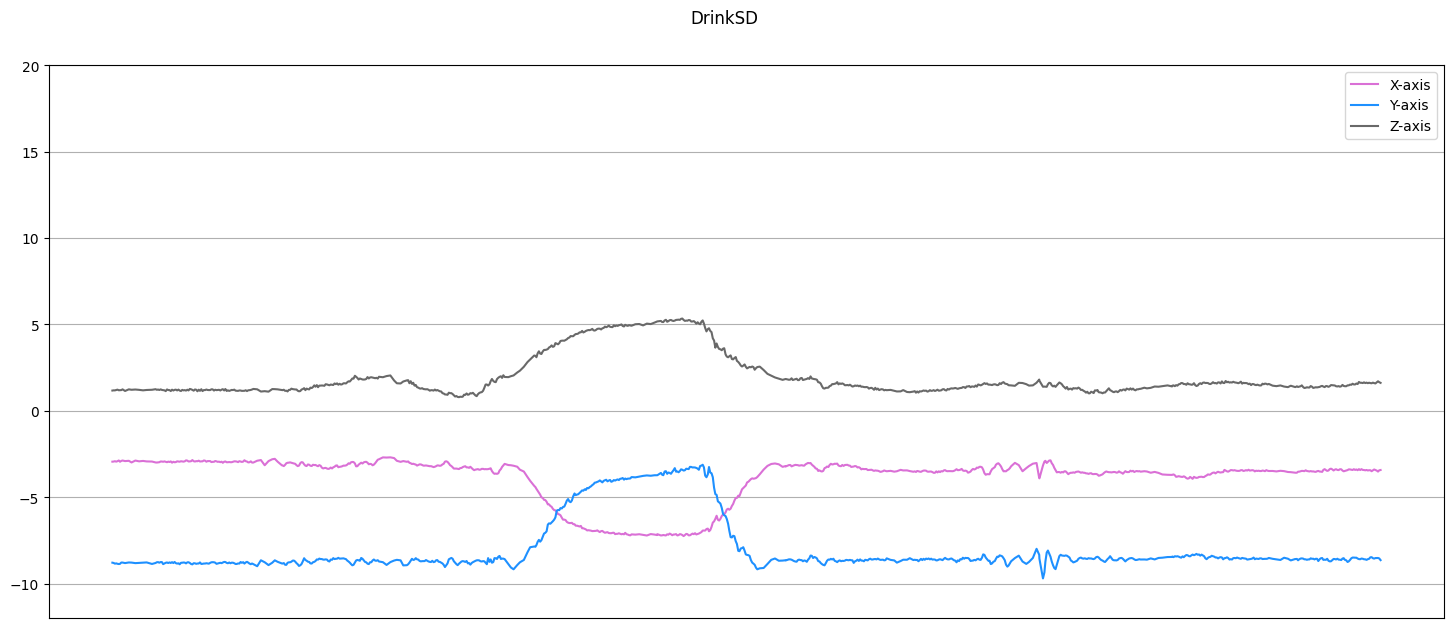

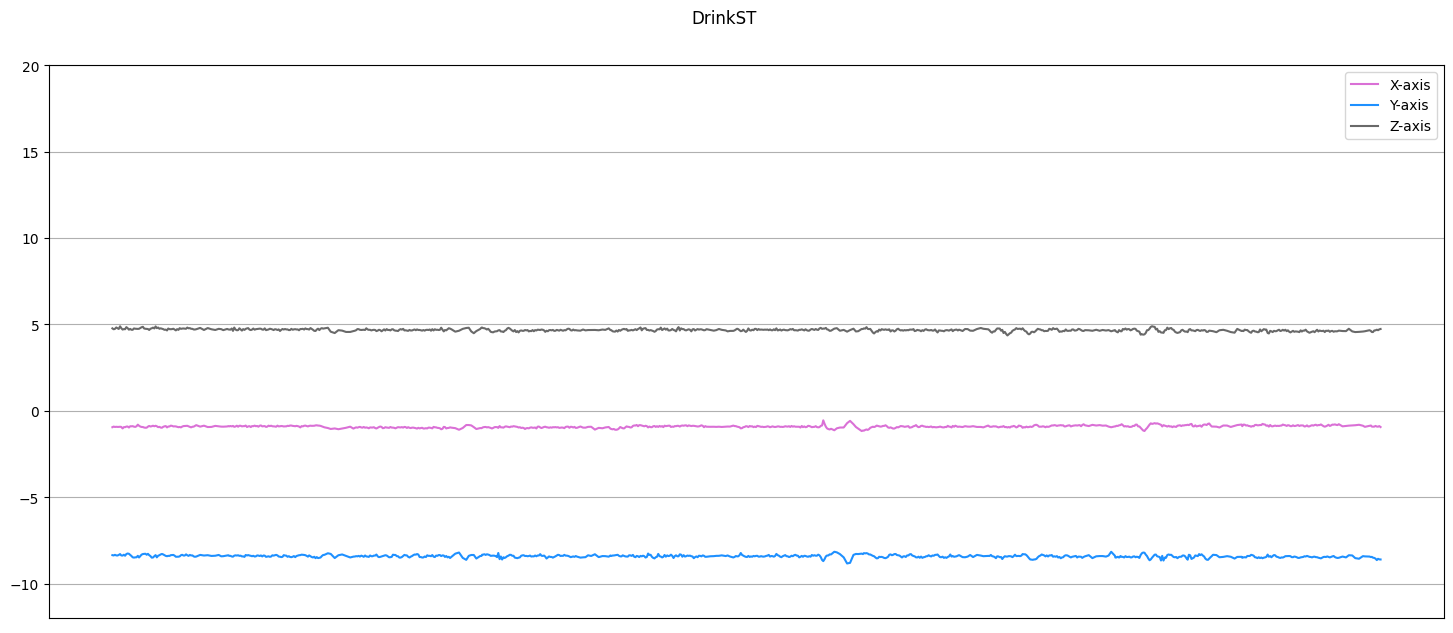

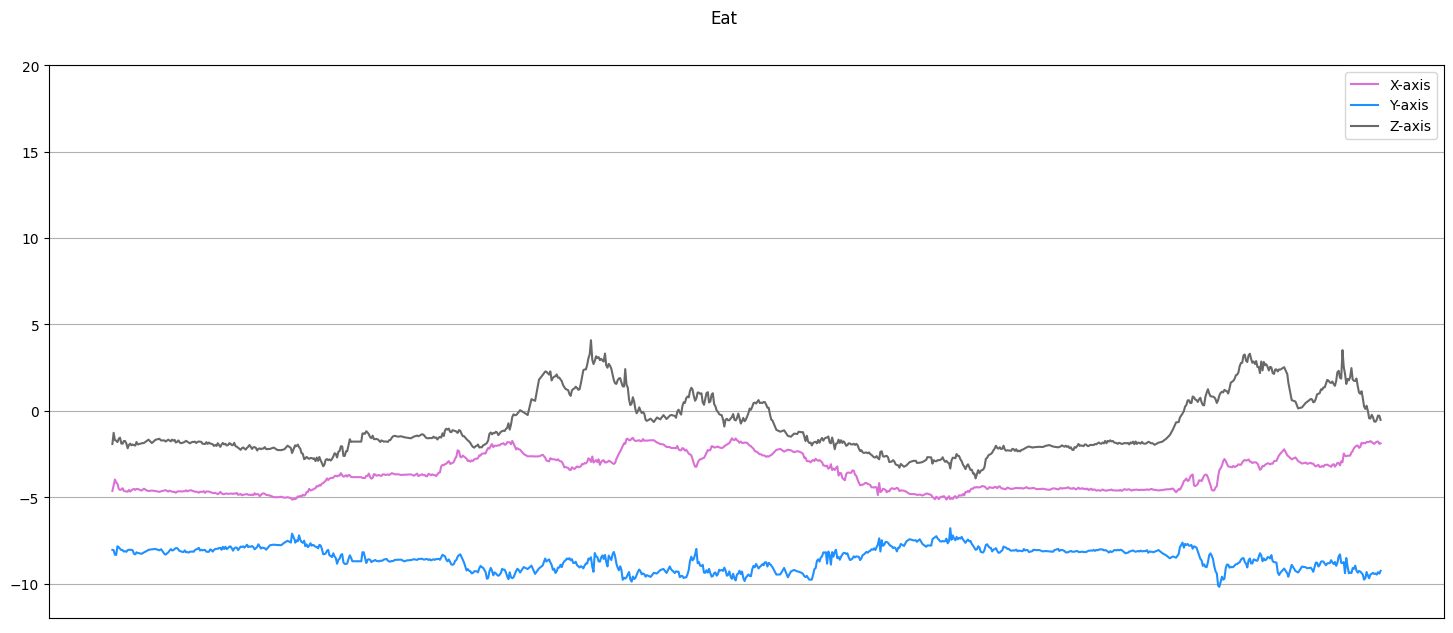

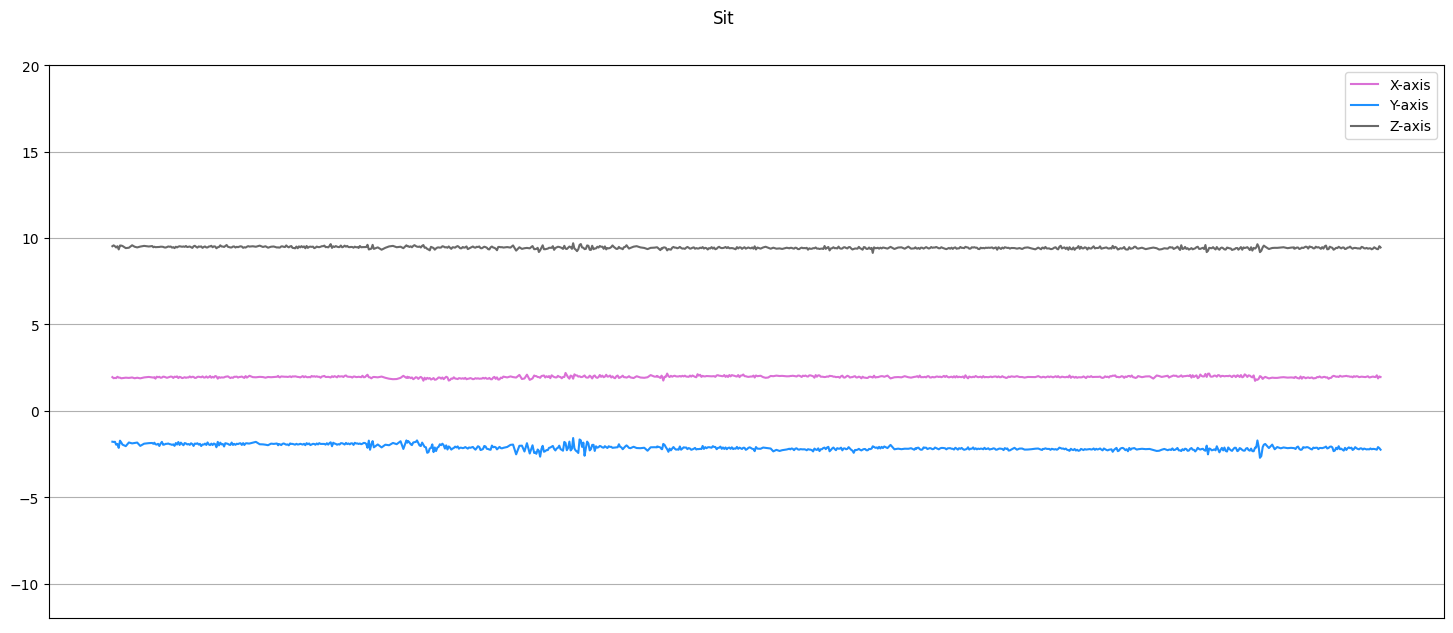

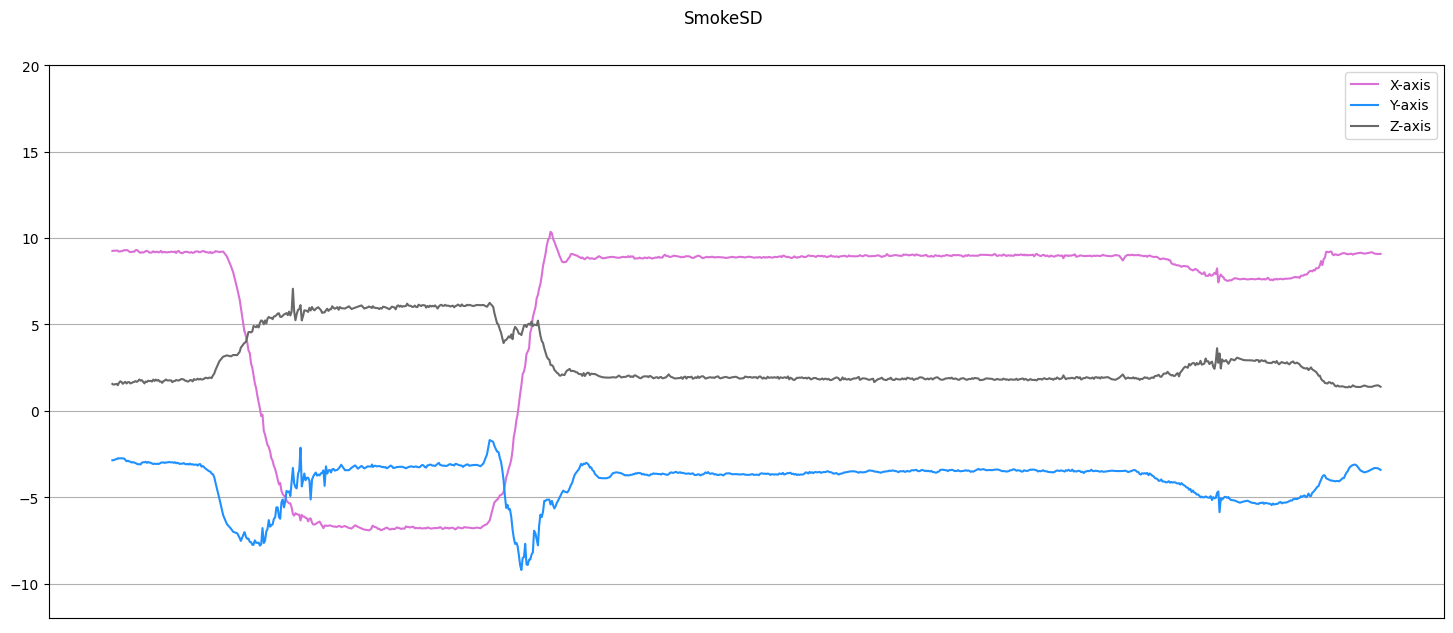

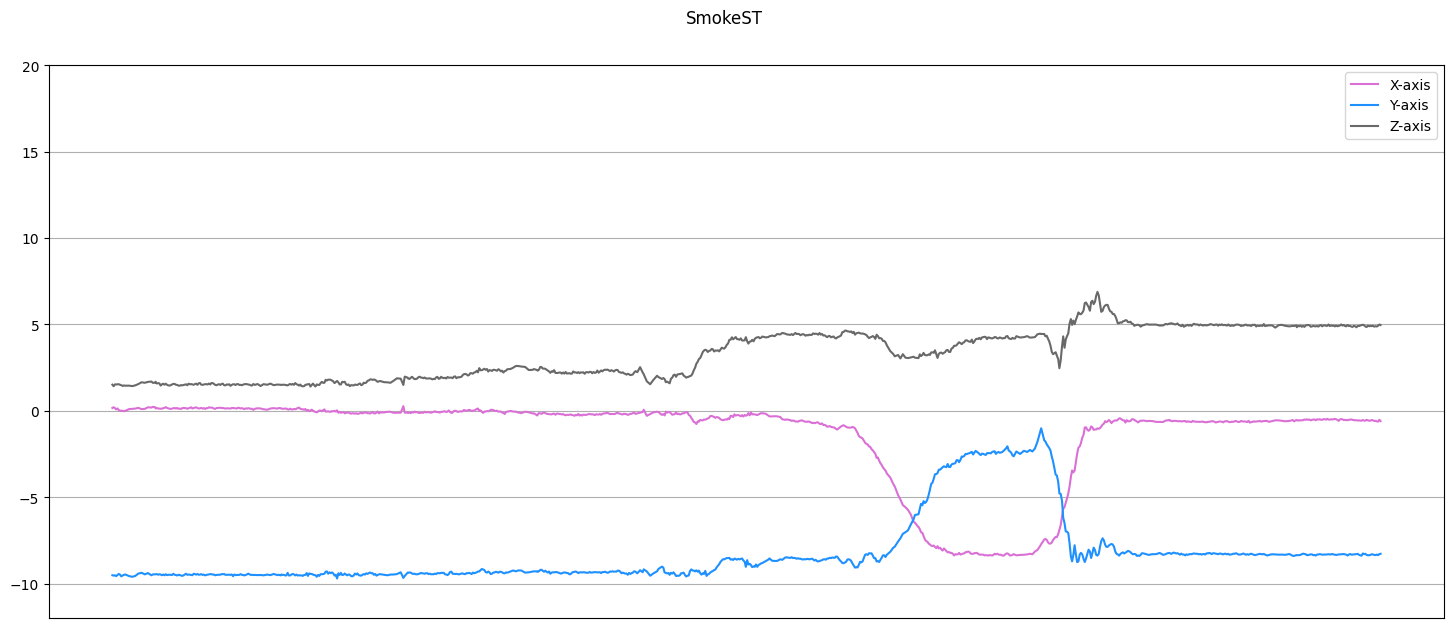

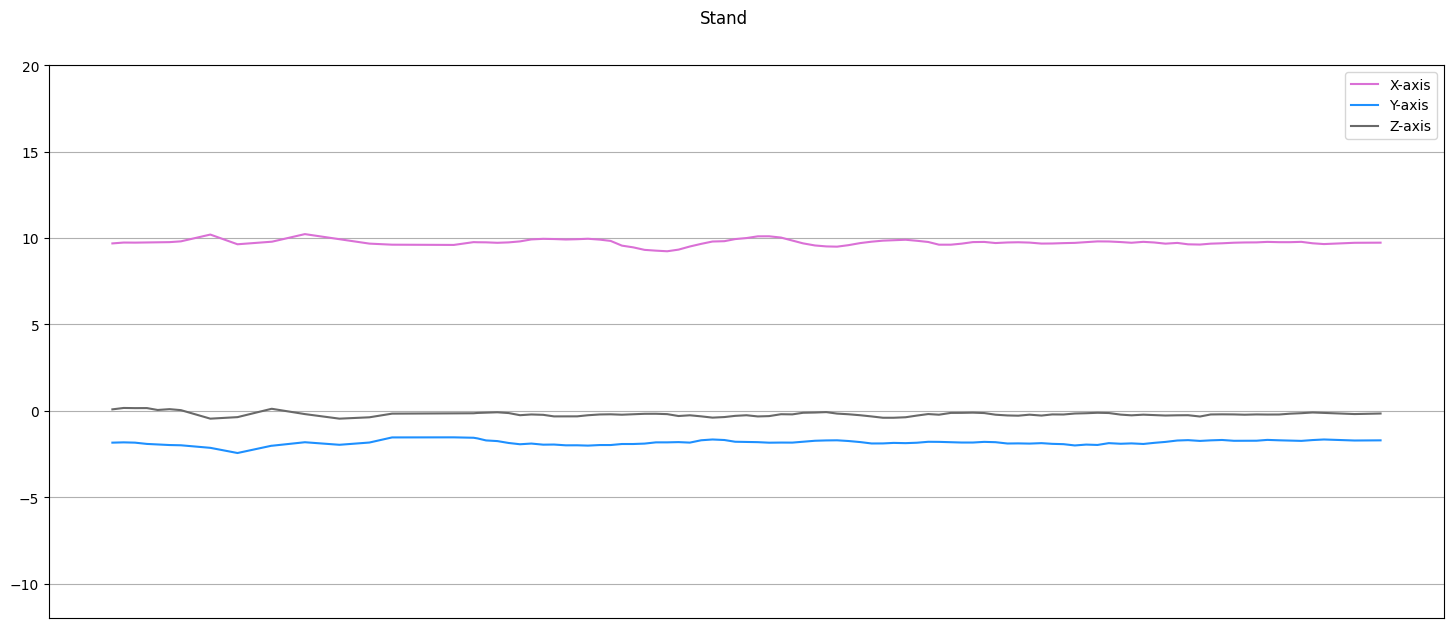

Participant4_Data.pickle


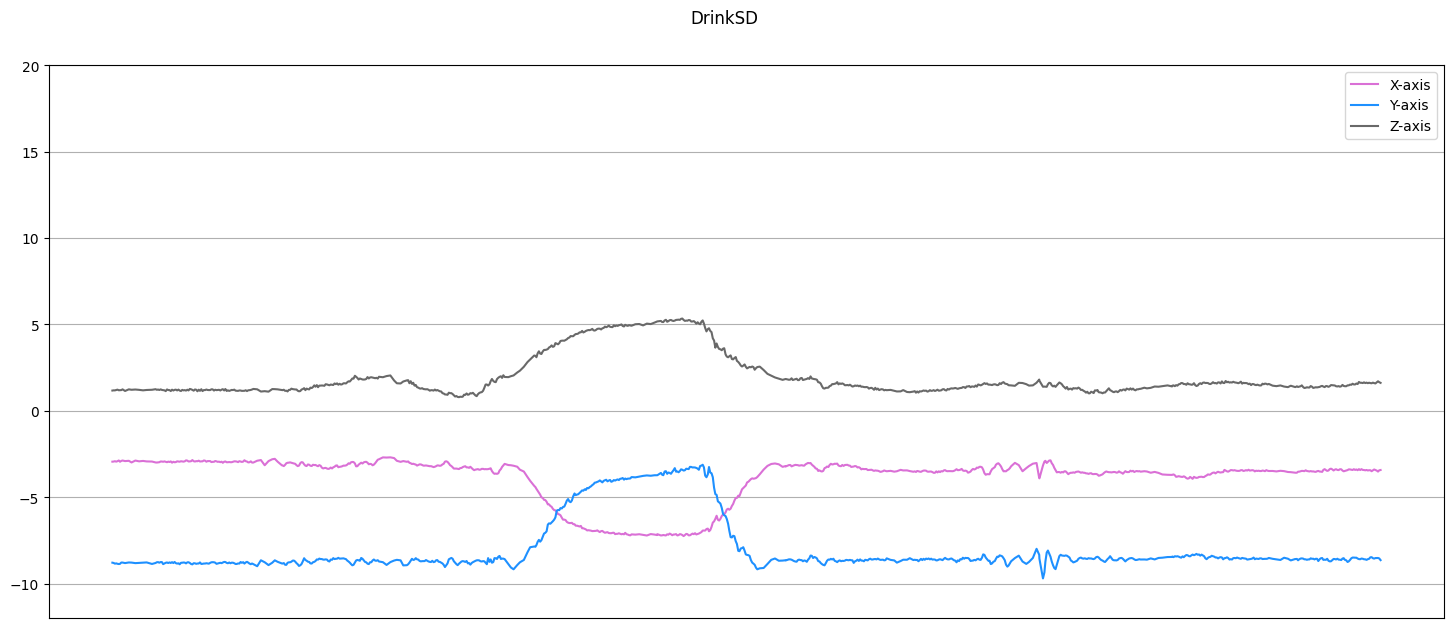

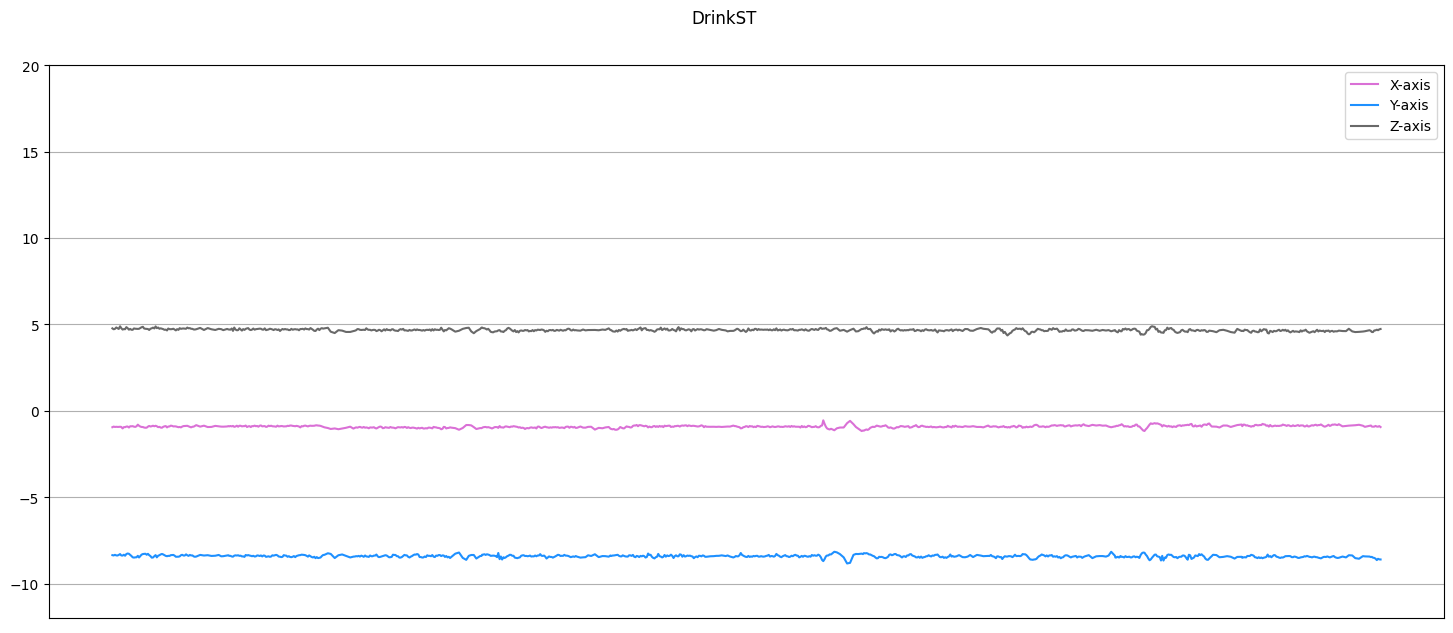

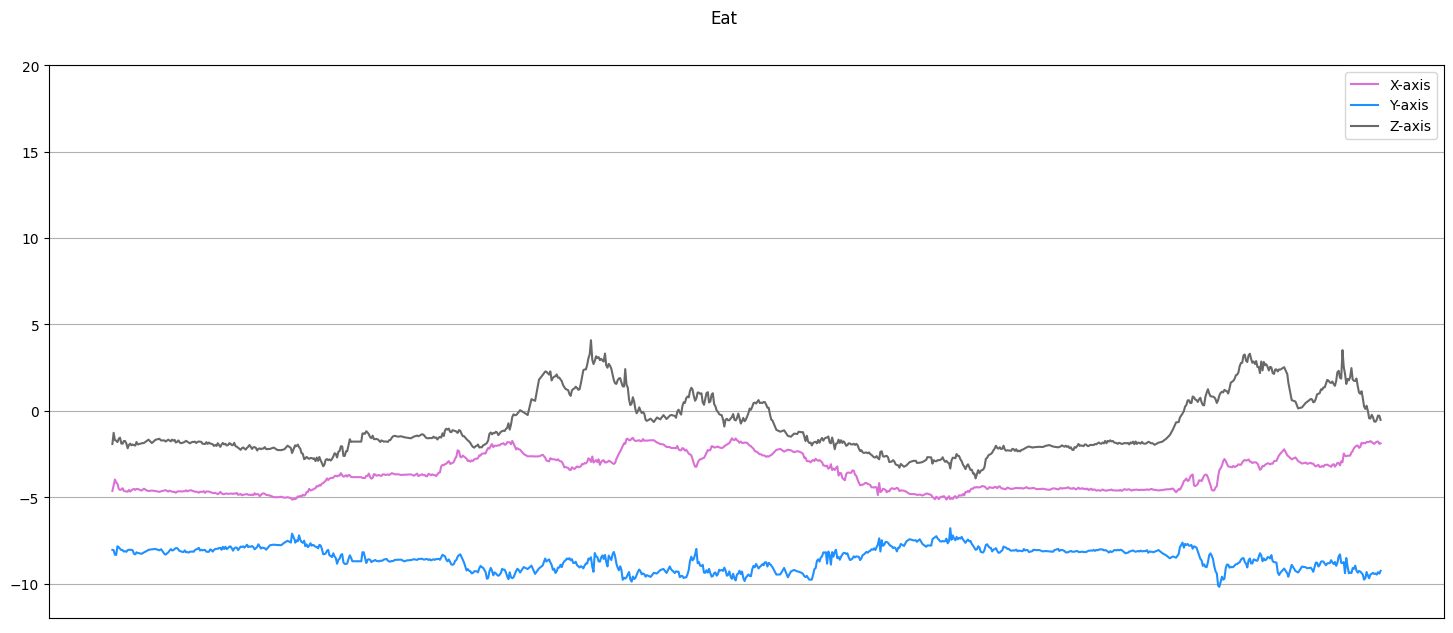

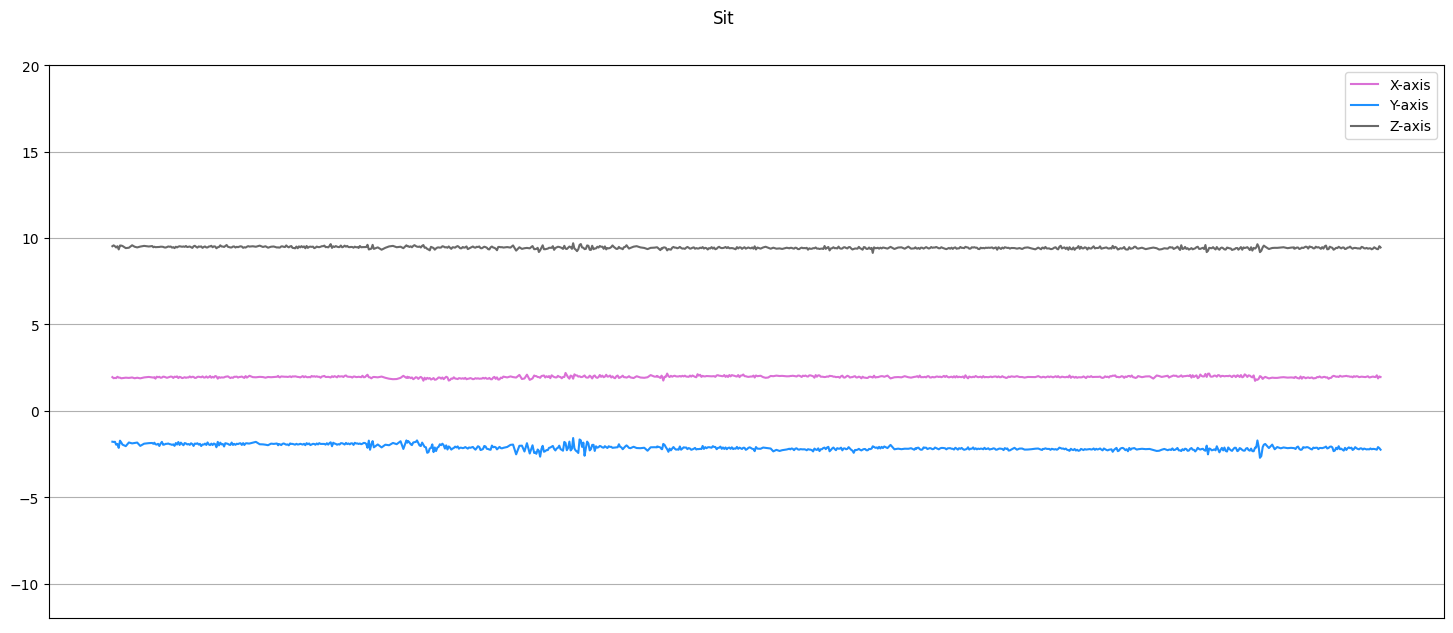

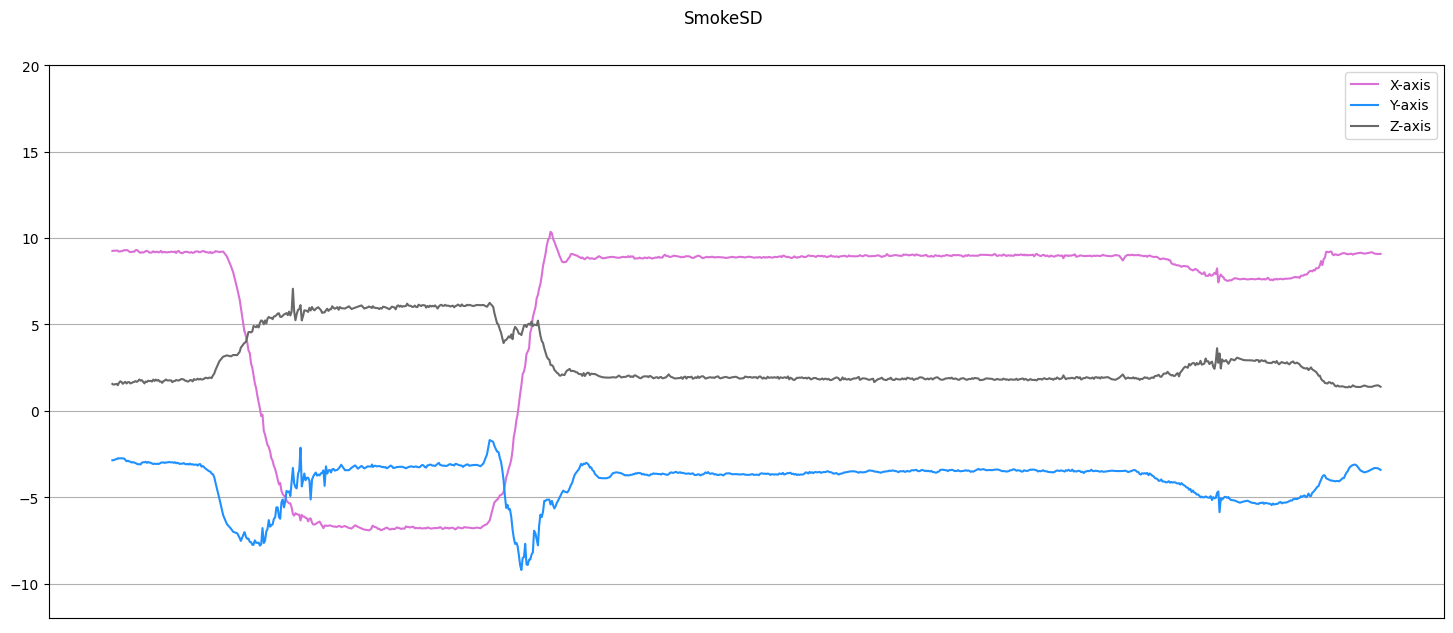

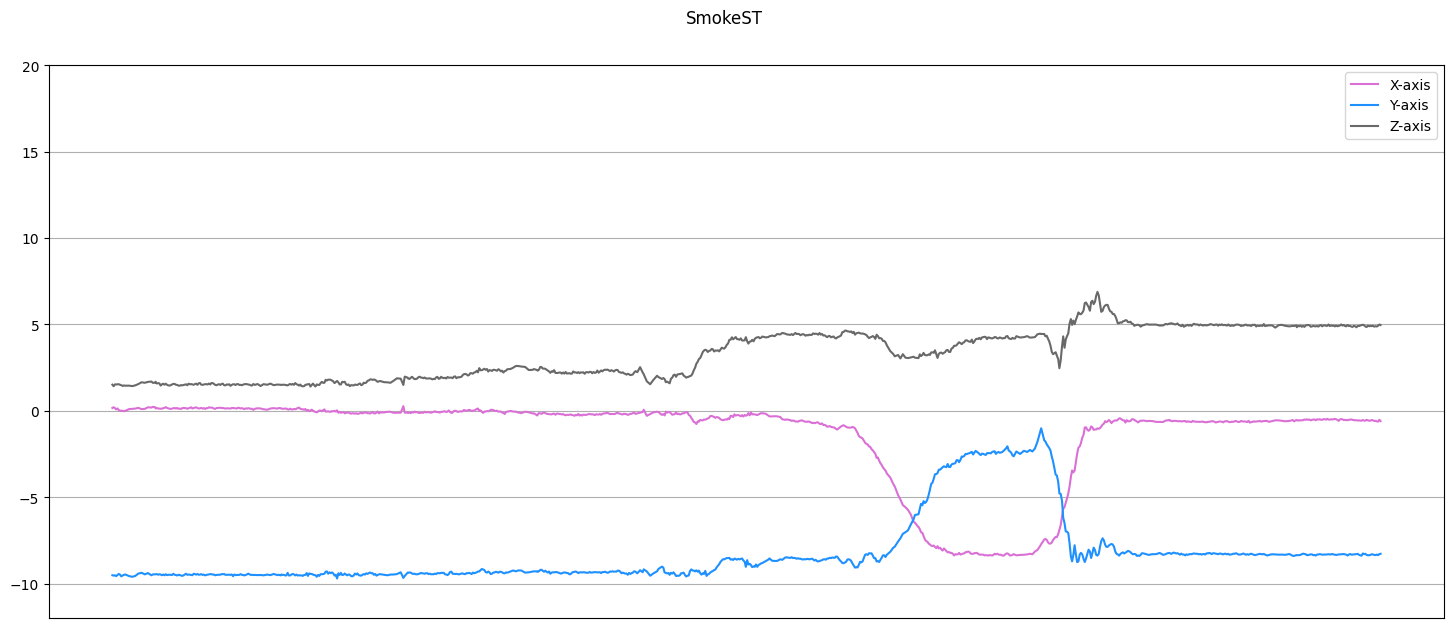

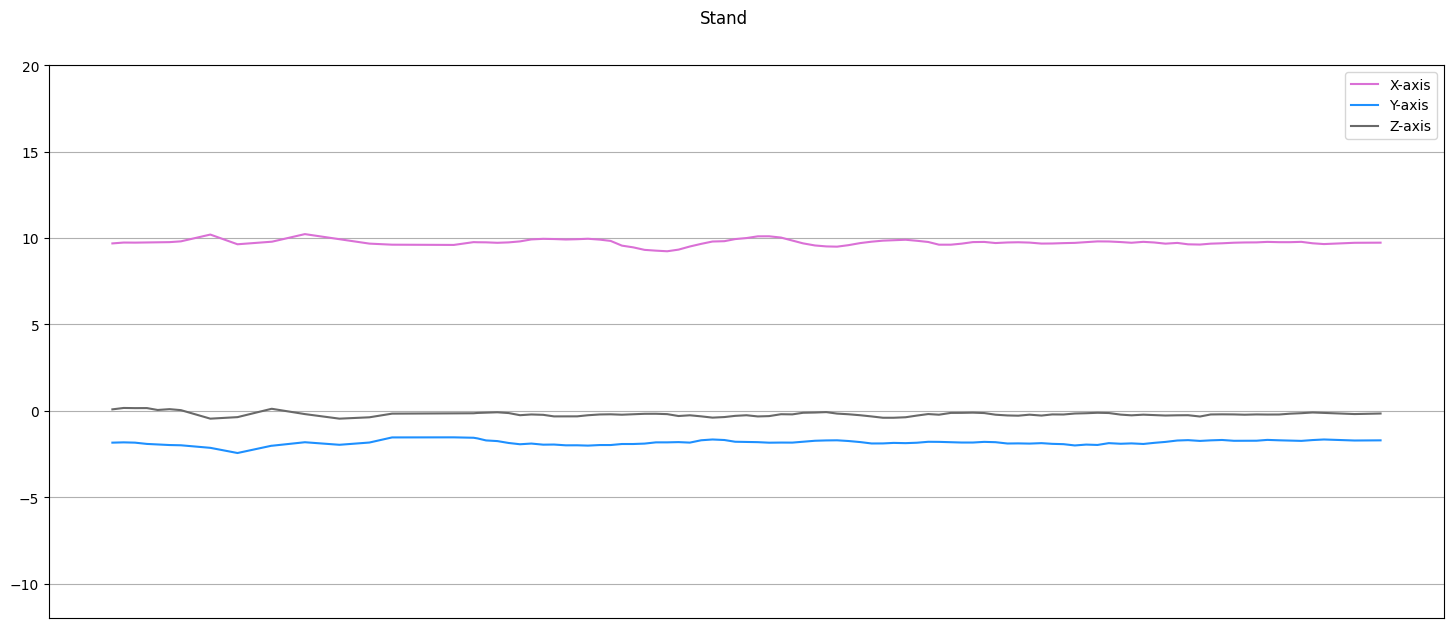

Participant5_Data.pickle


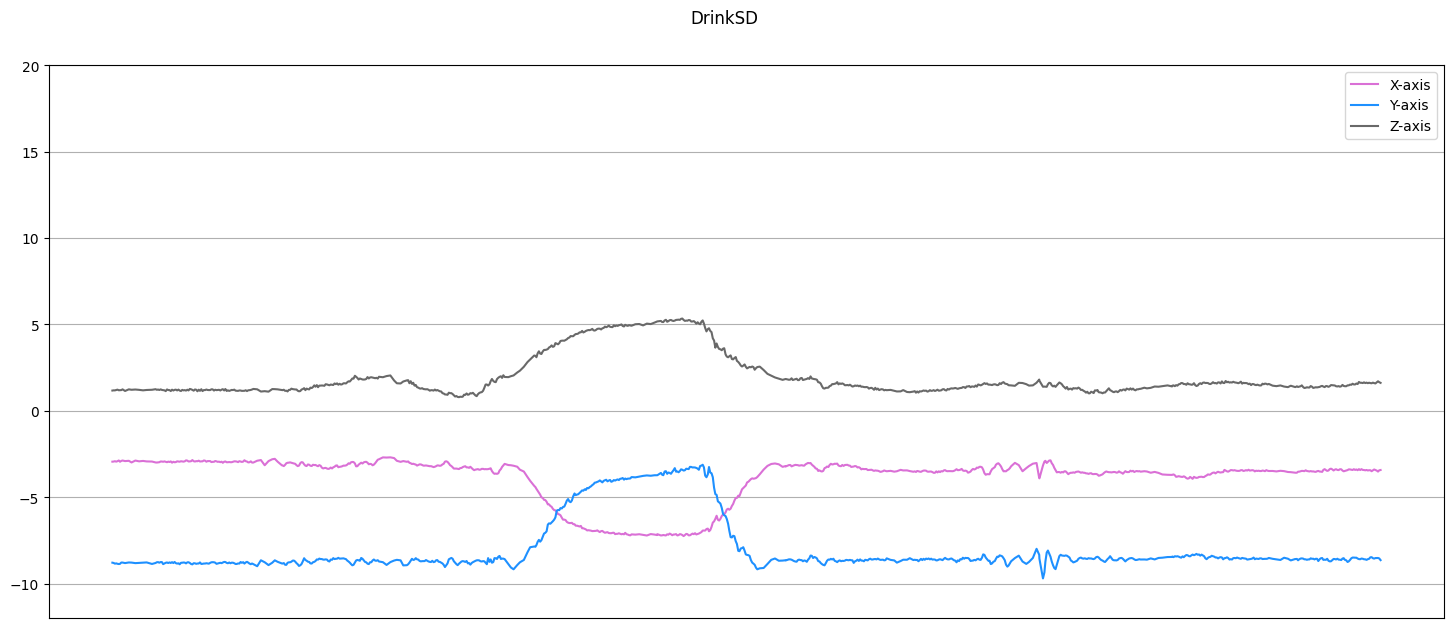

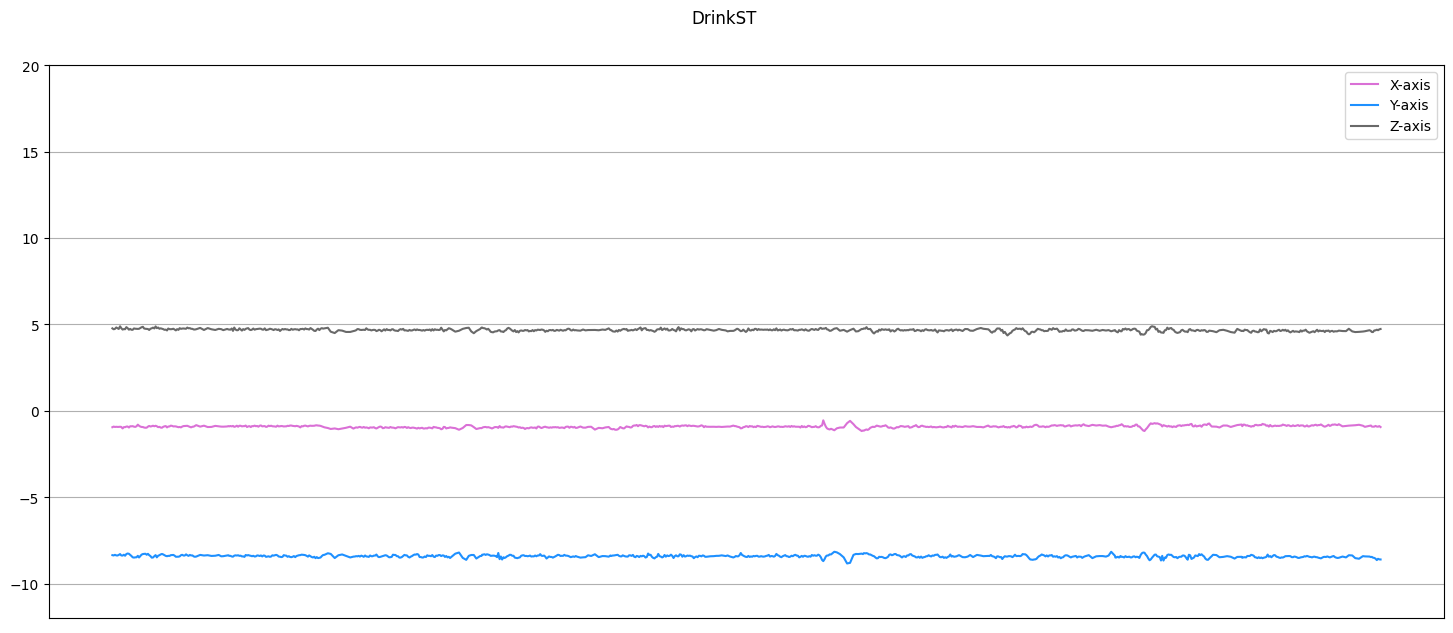

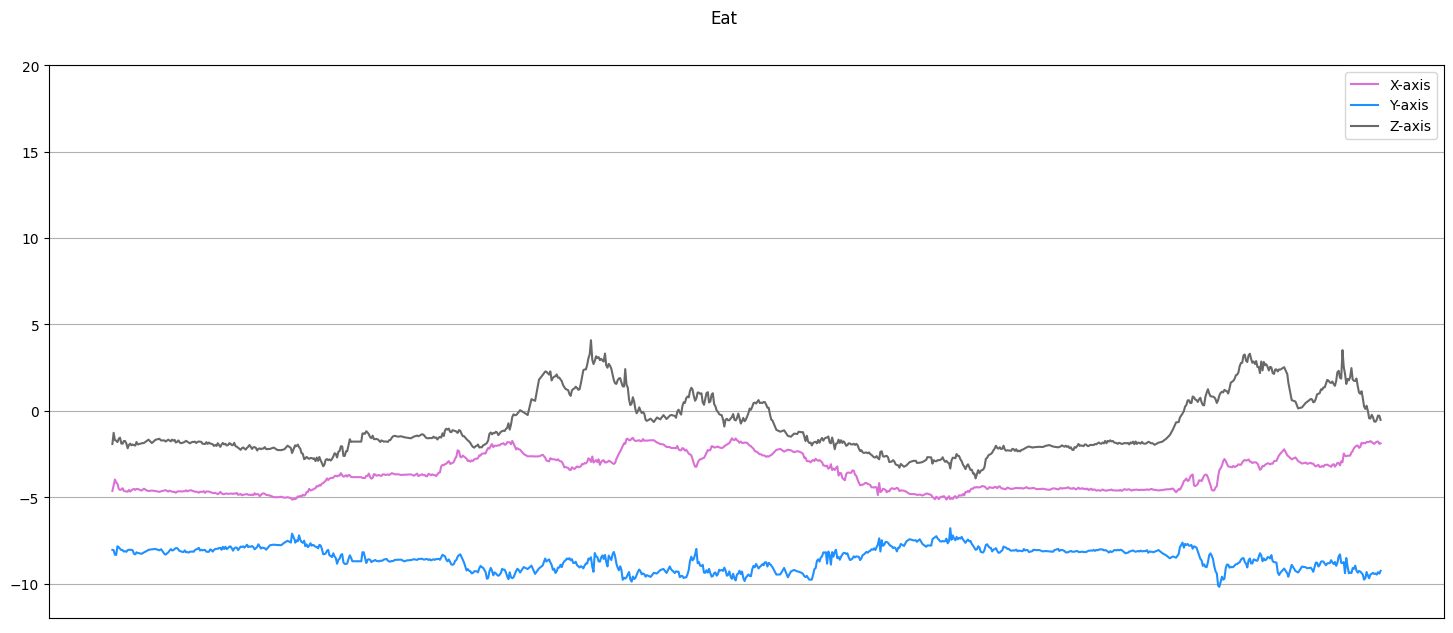

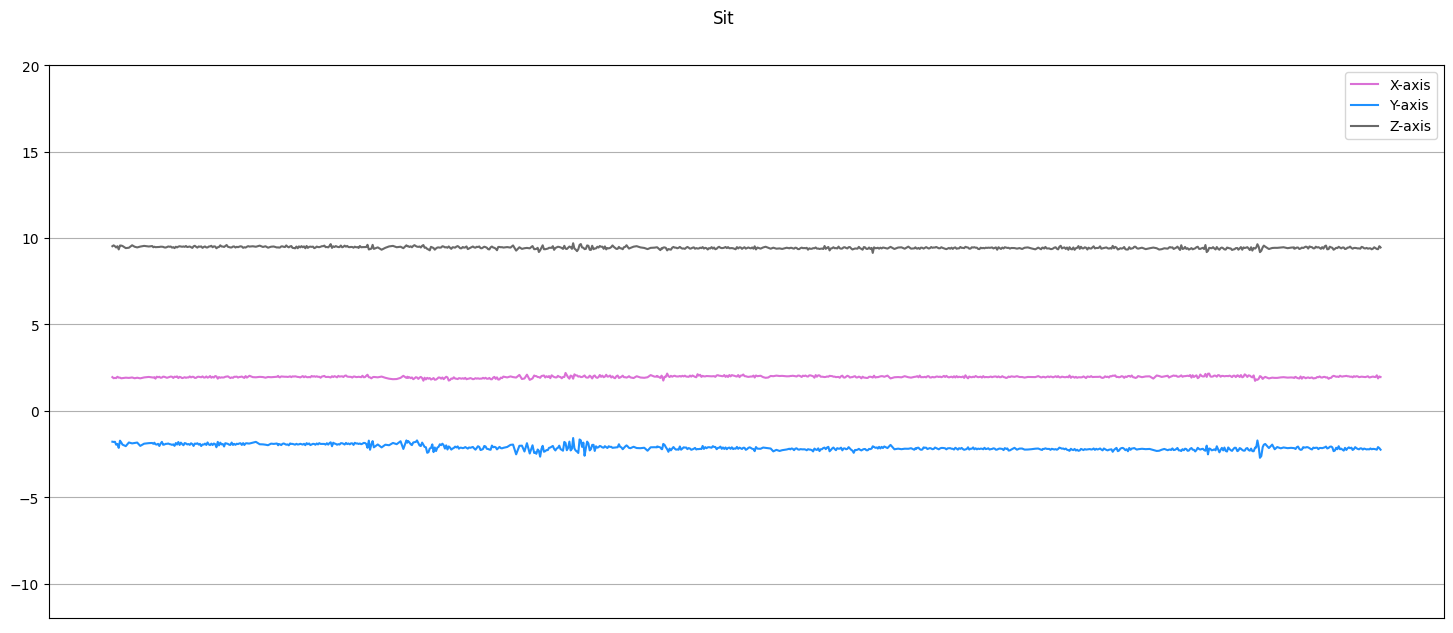

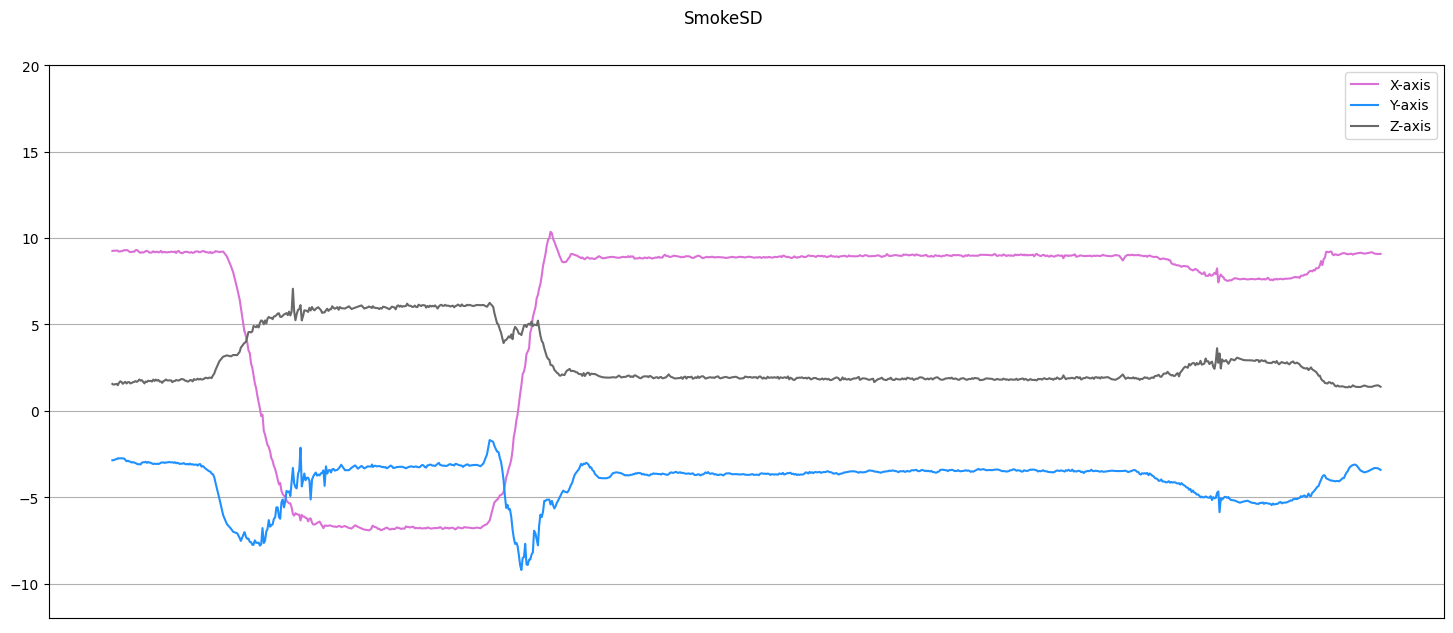

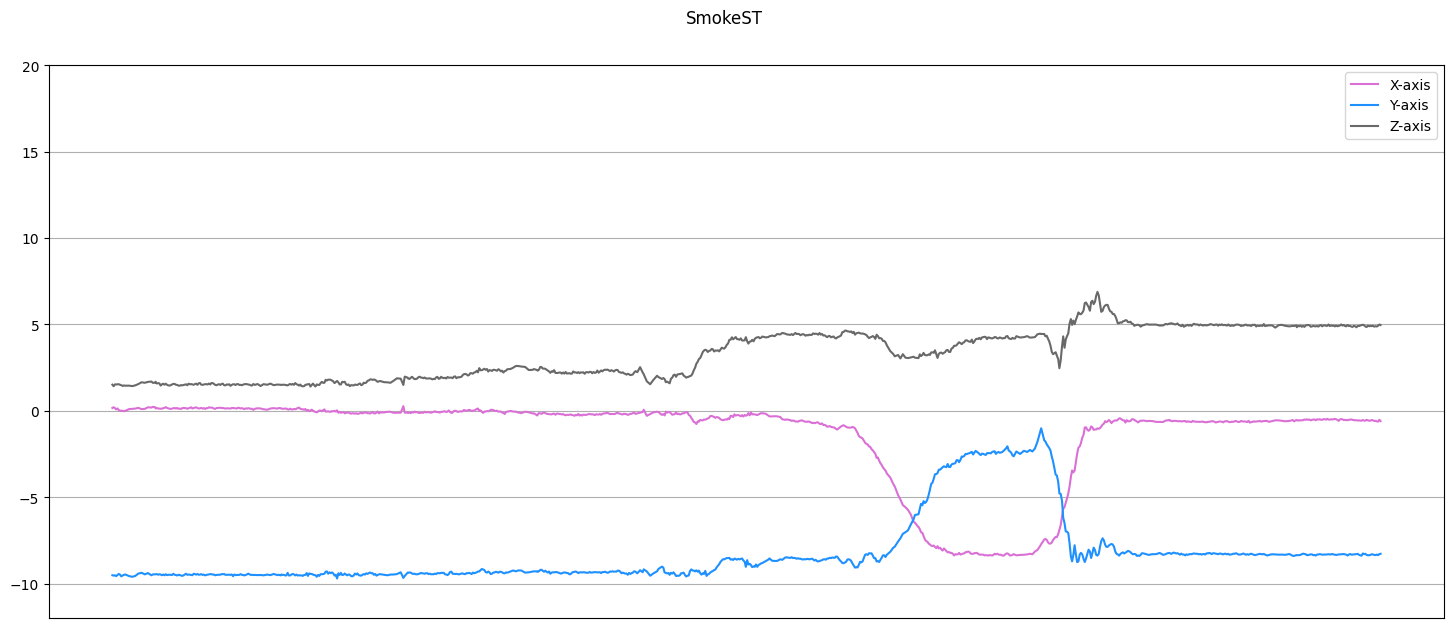

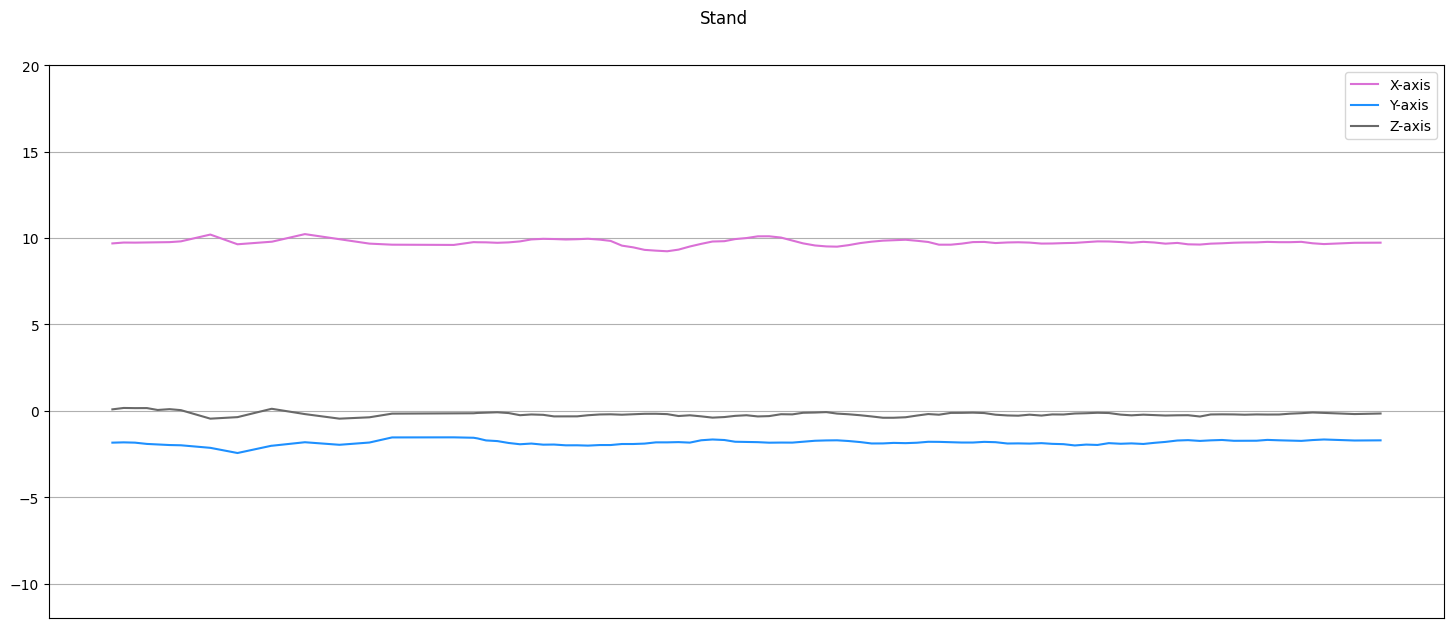

Participant6_Data.pickle


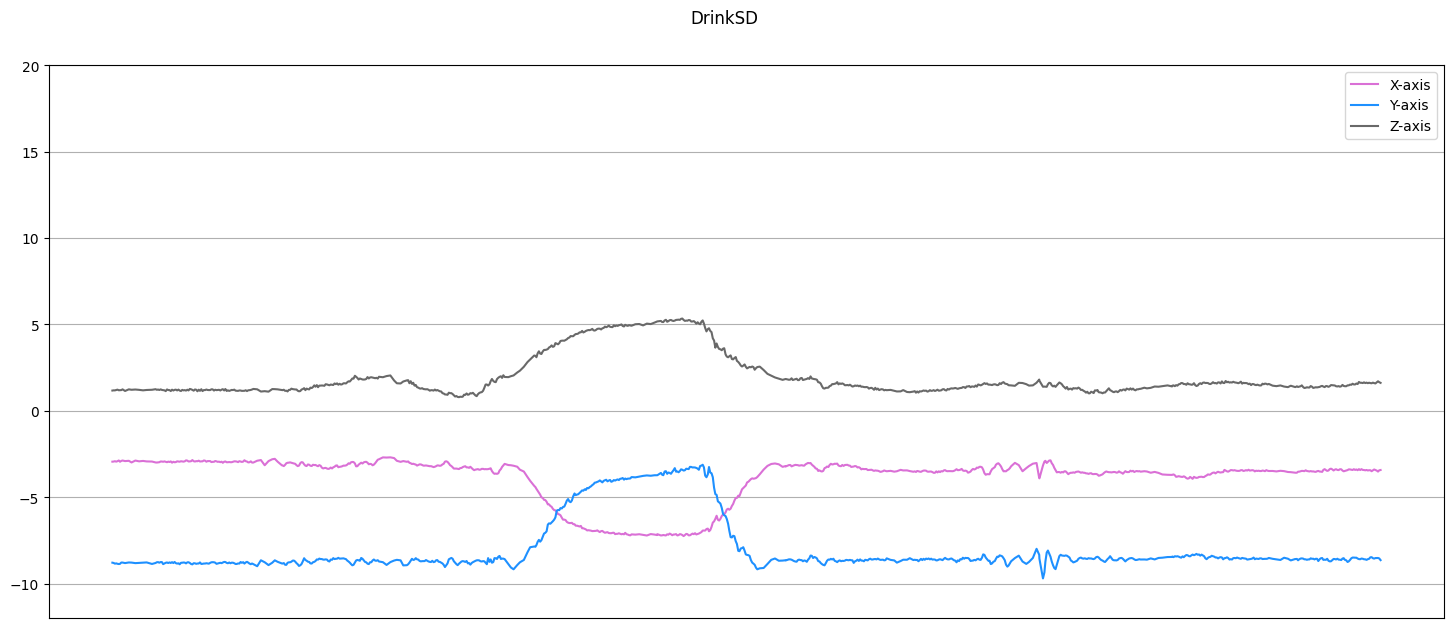

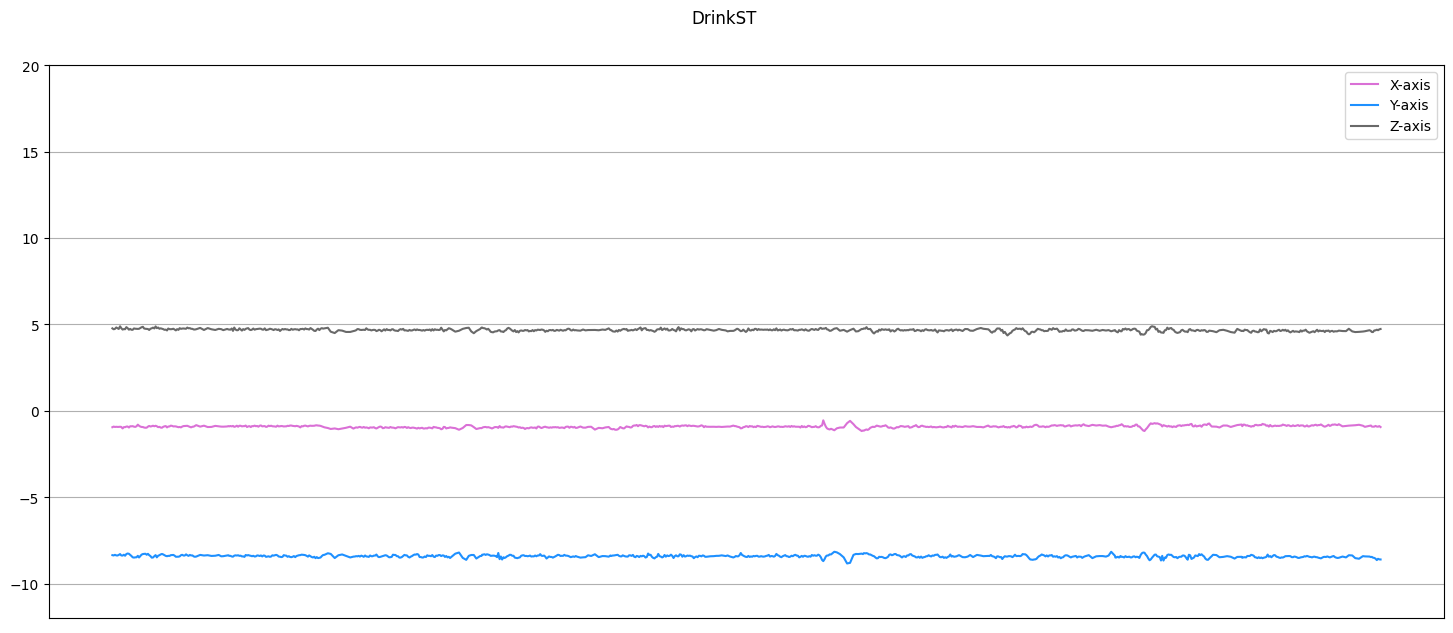

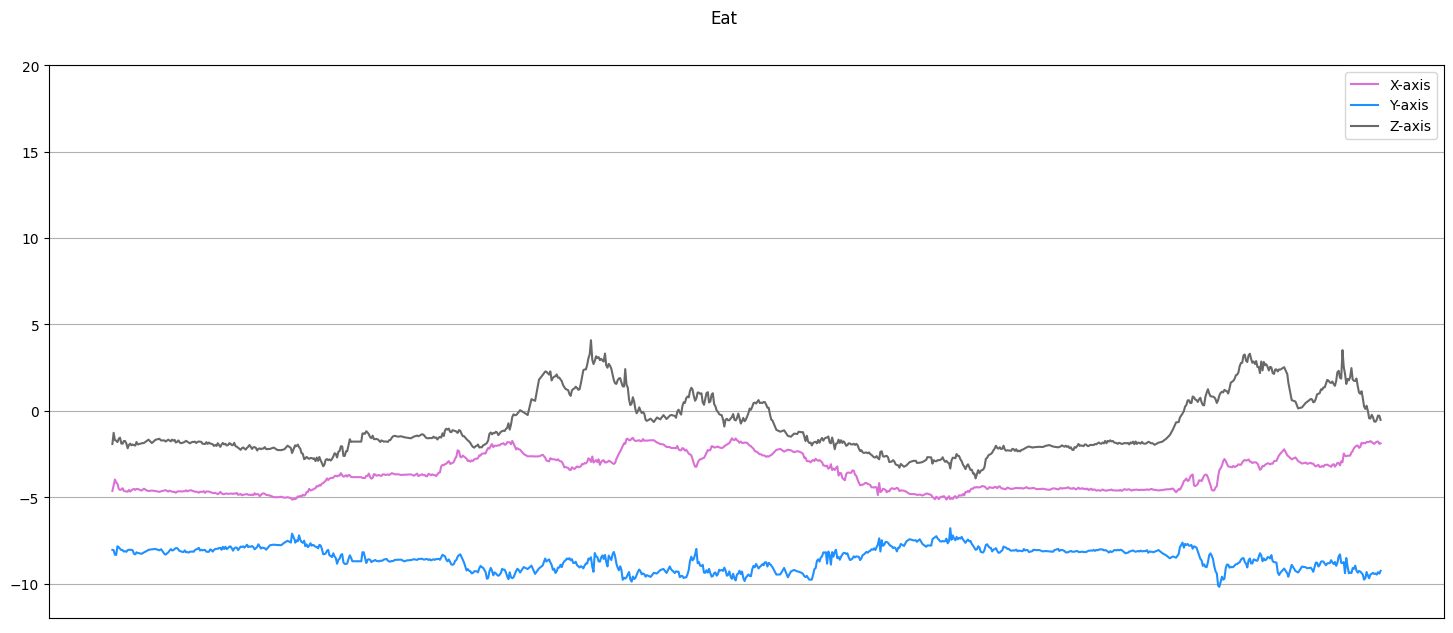

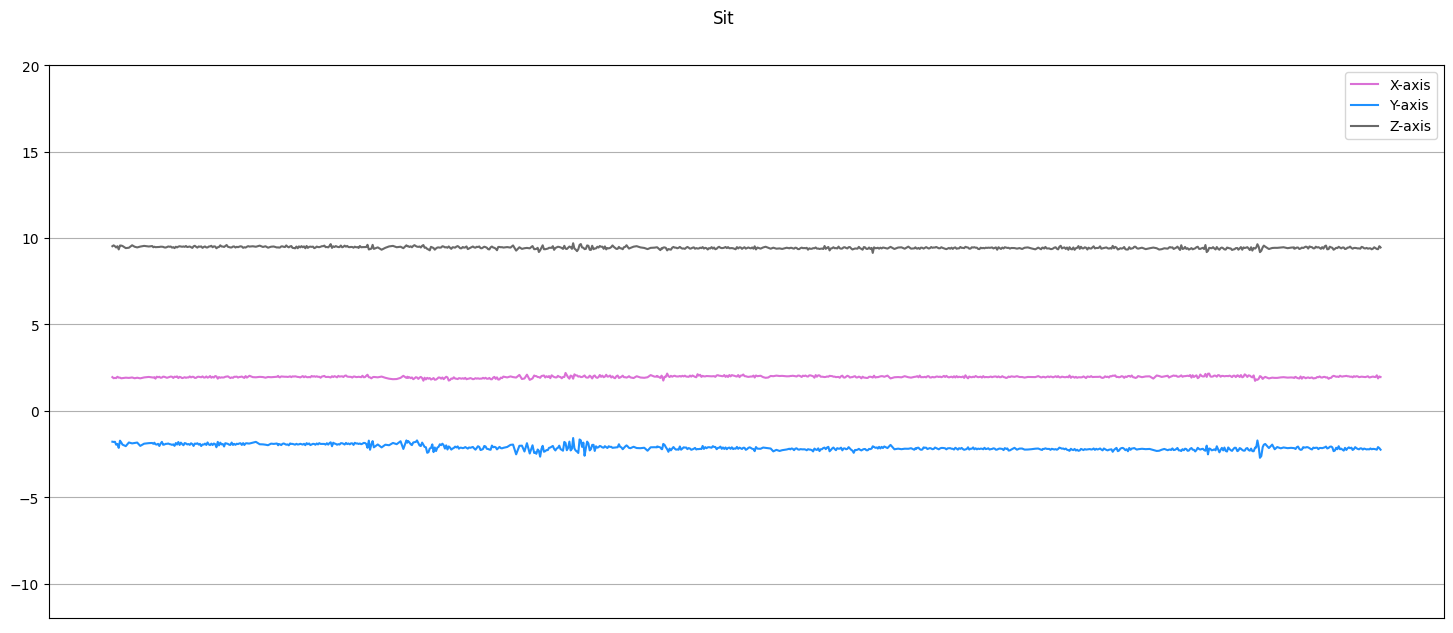

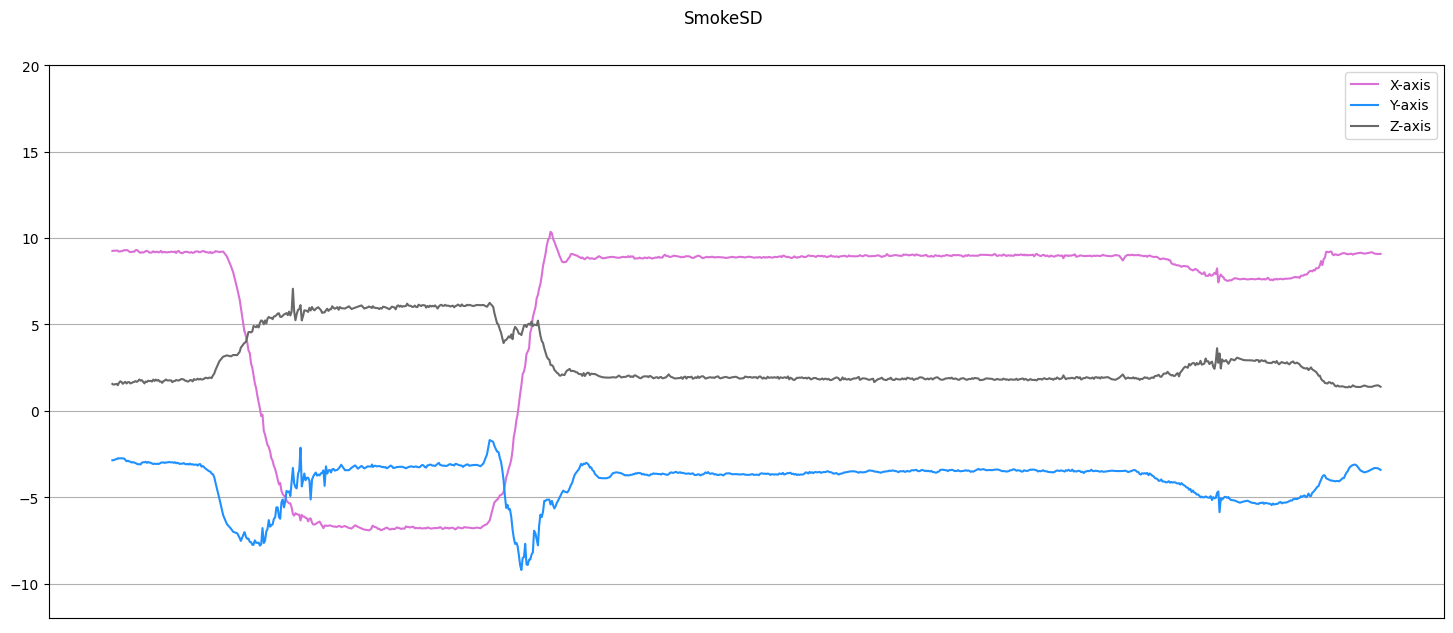

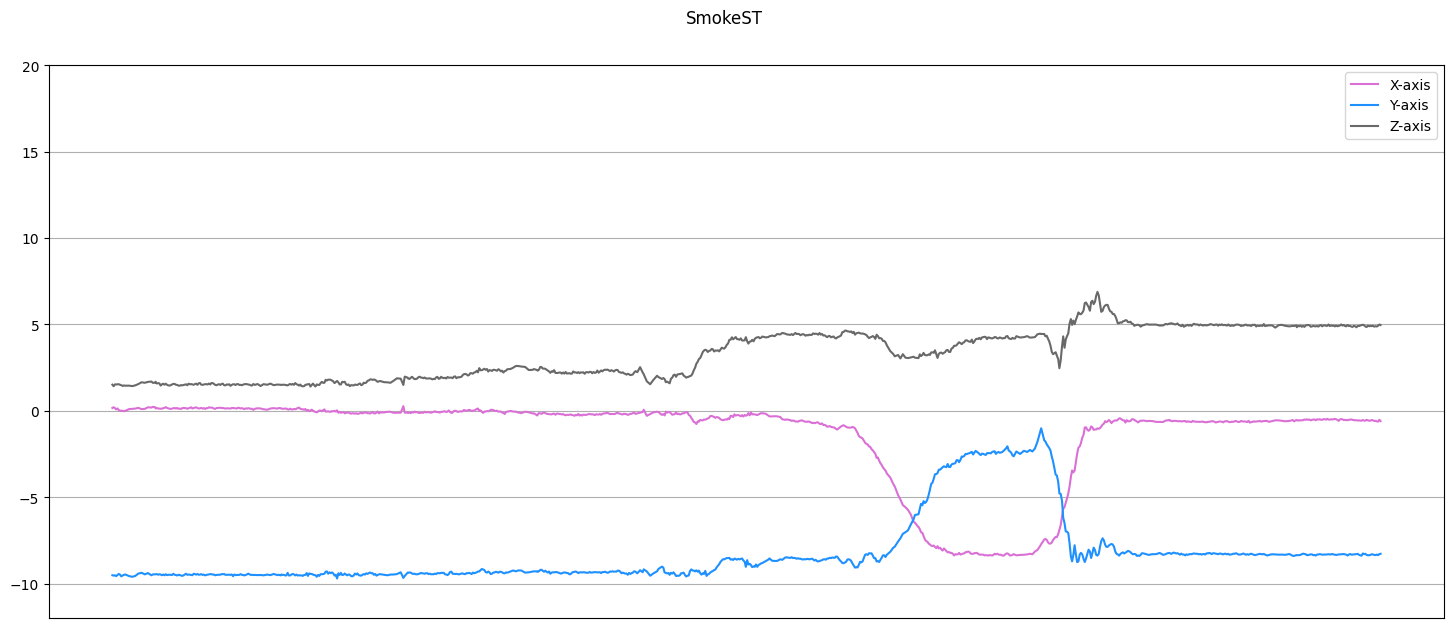

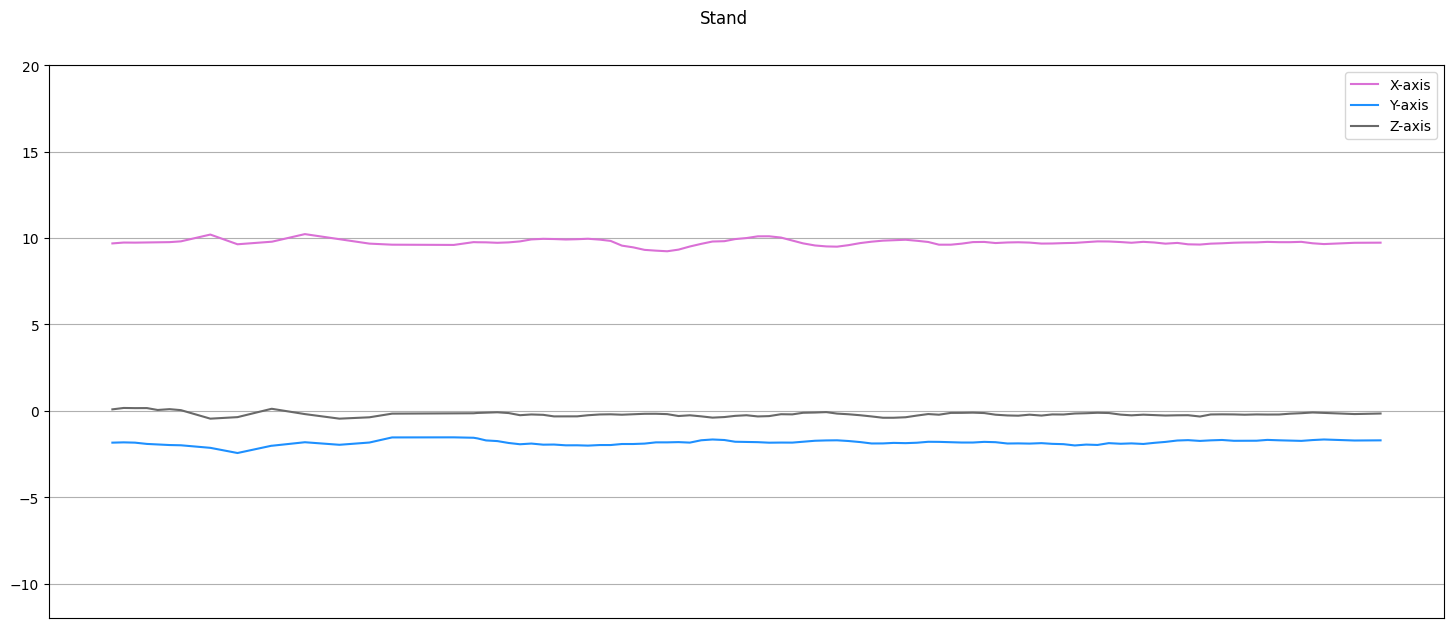

Participant7_Data.pickle


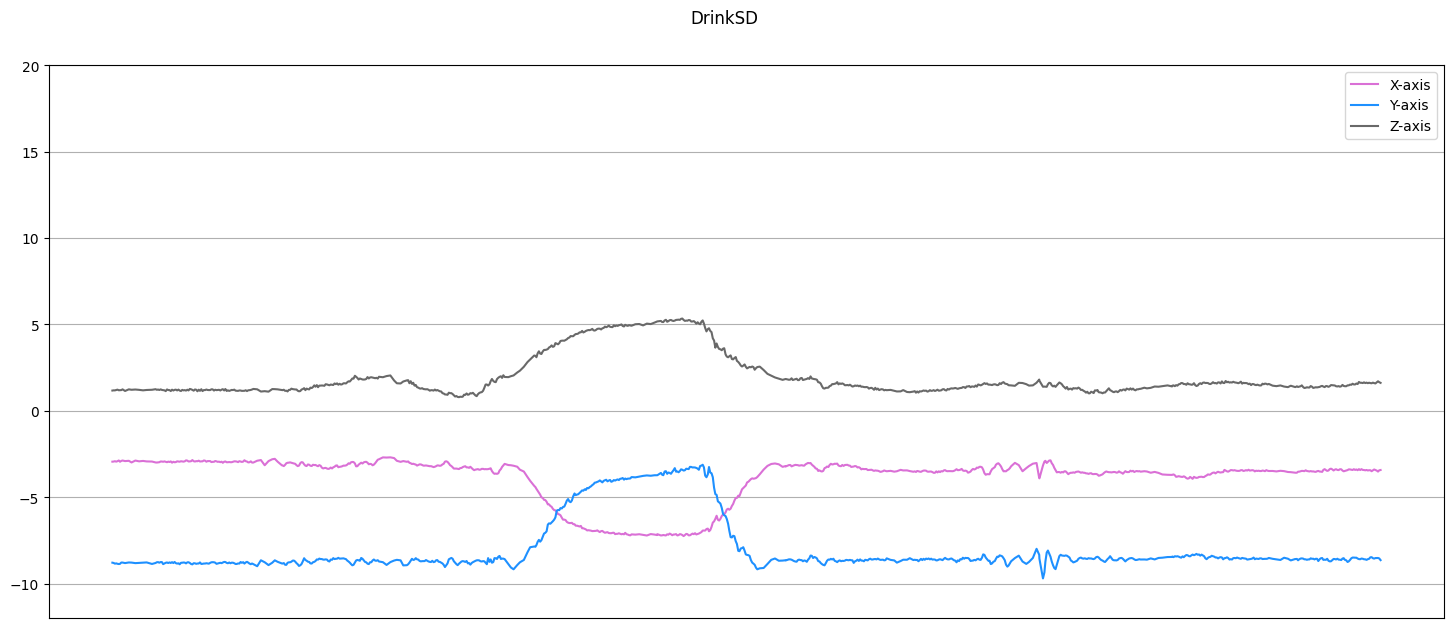

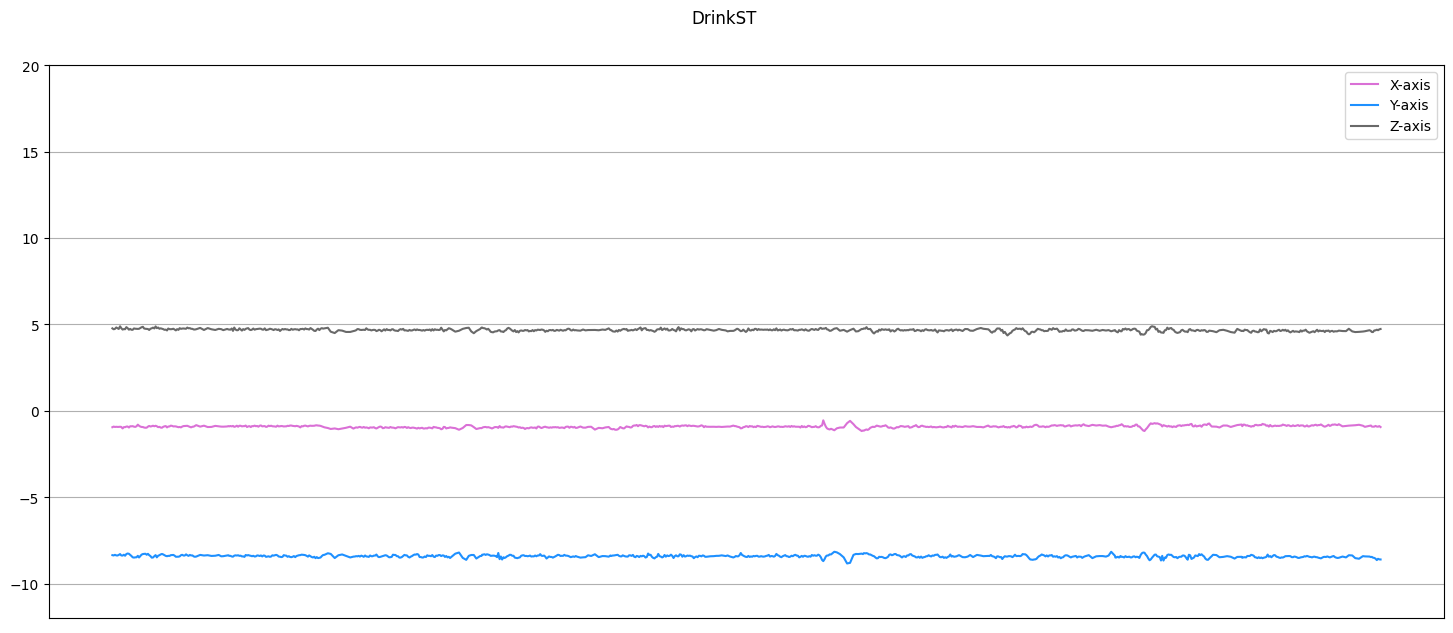

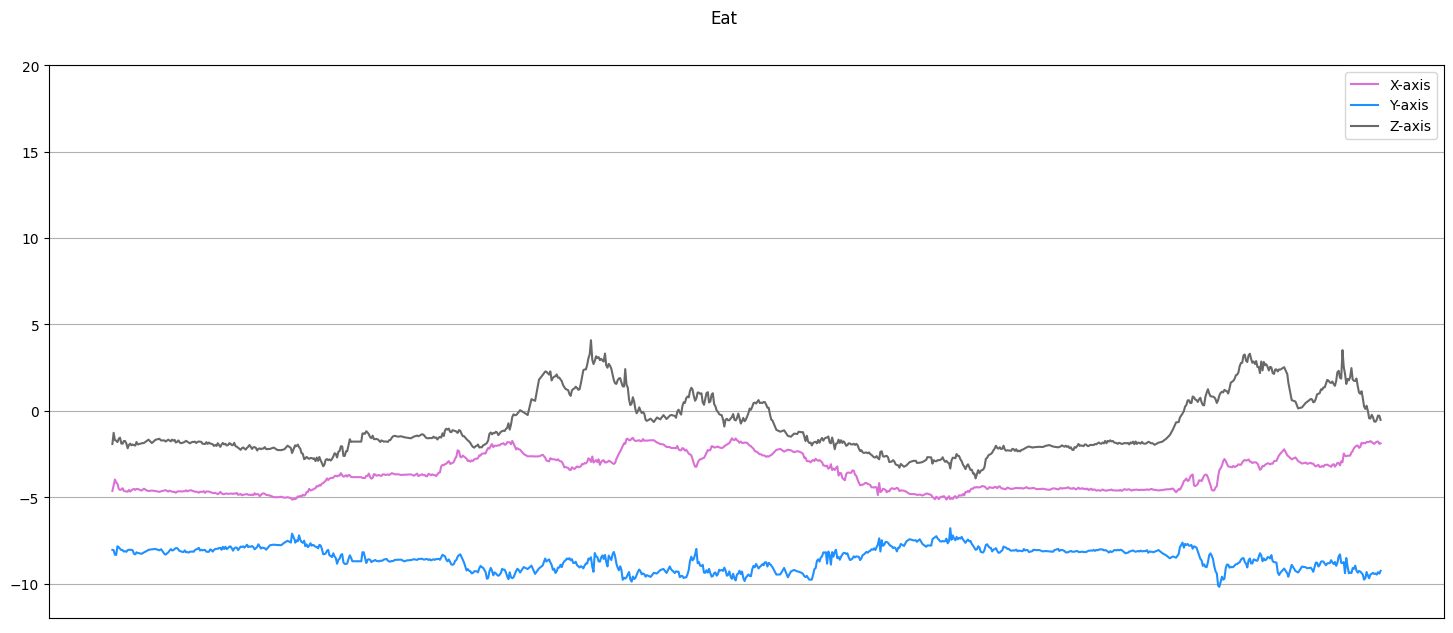

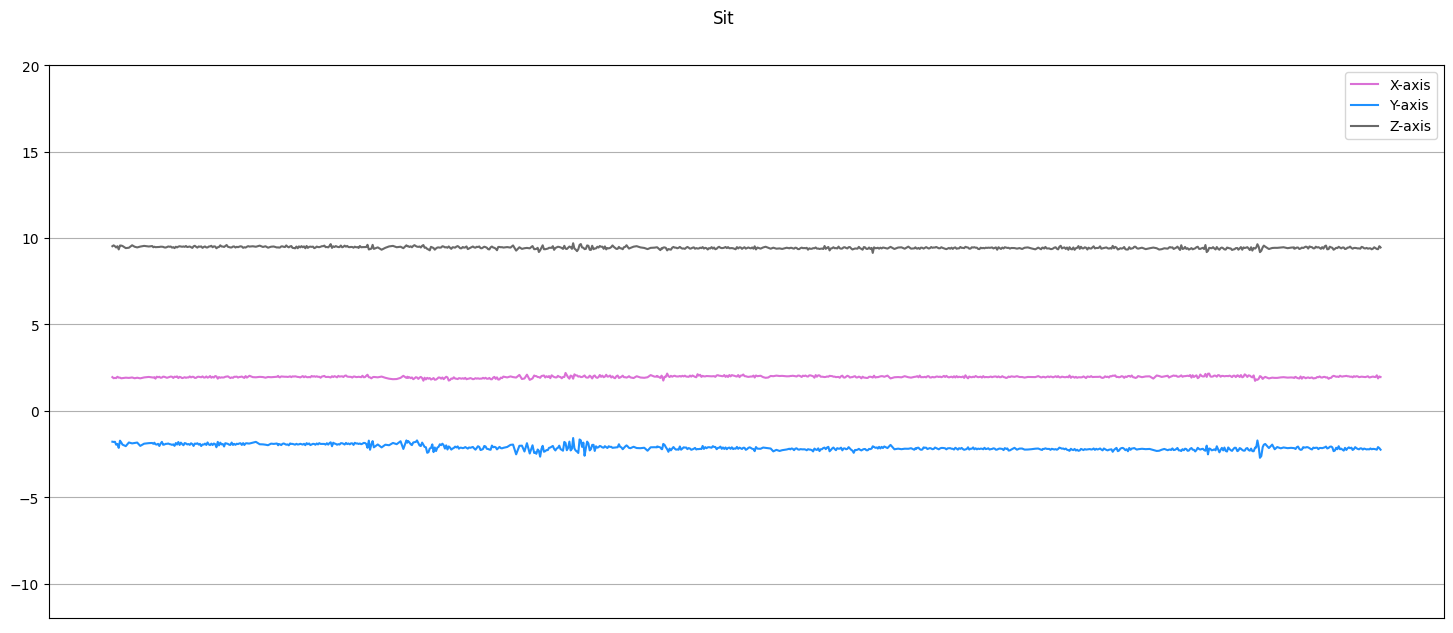

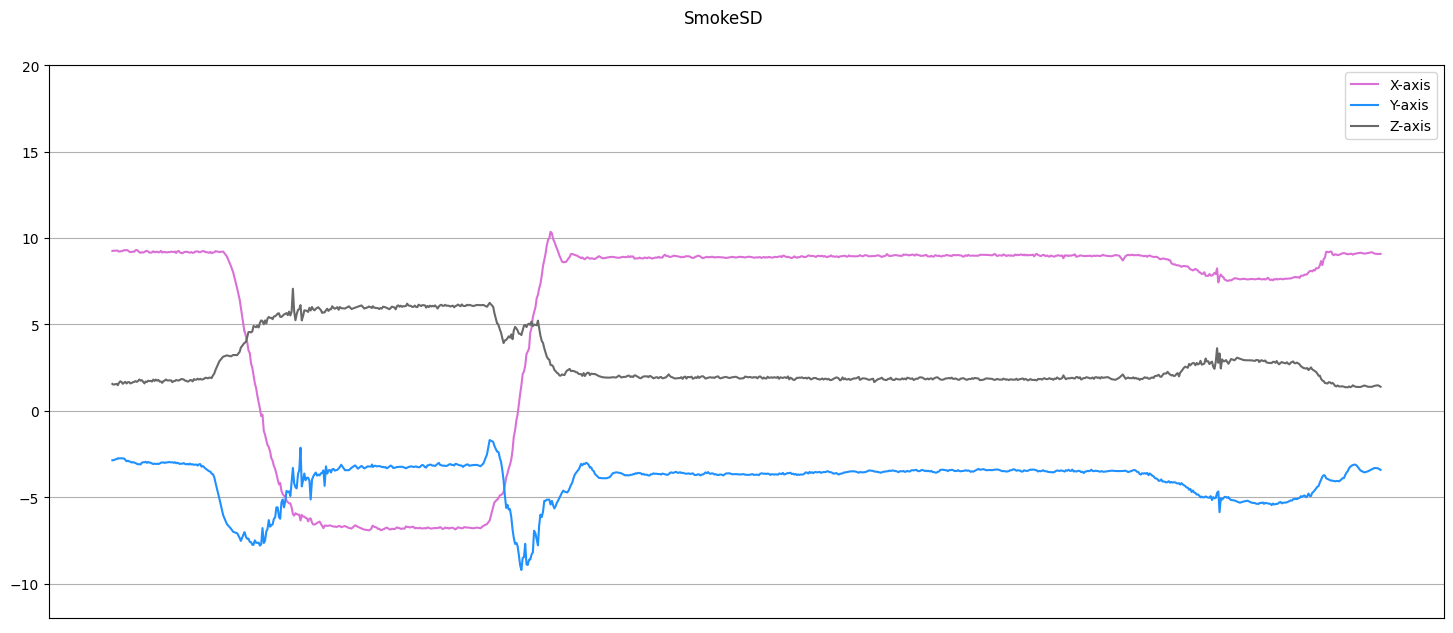

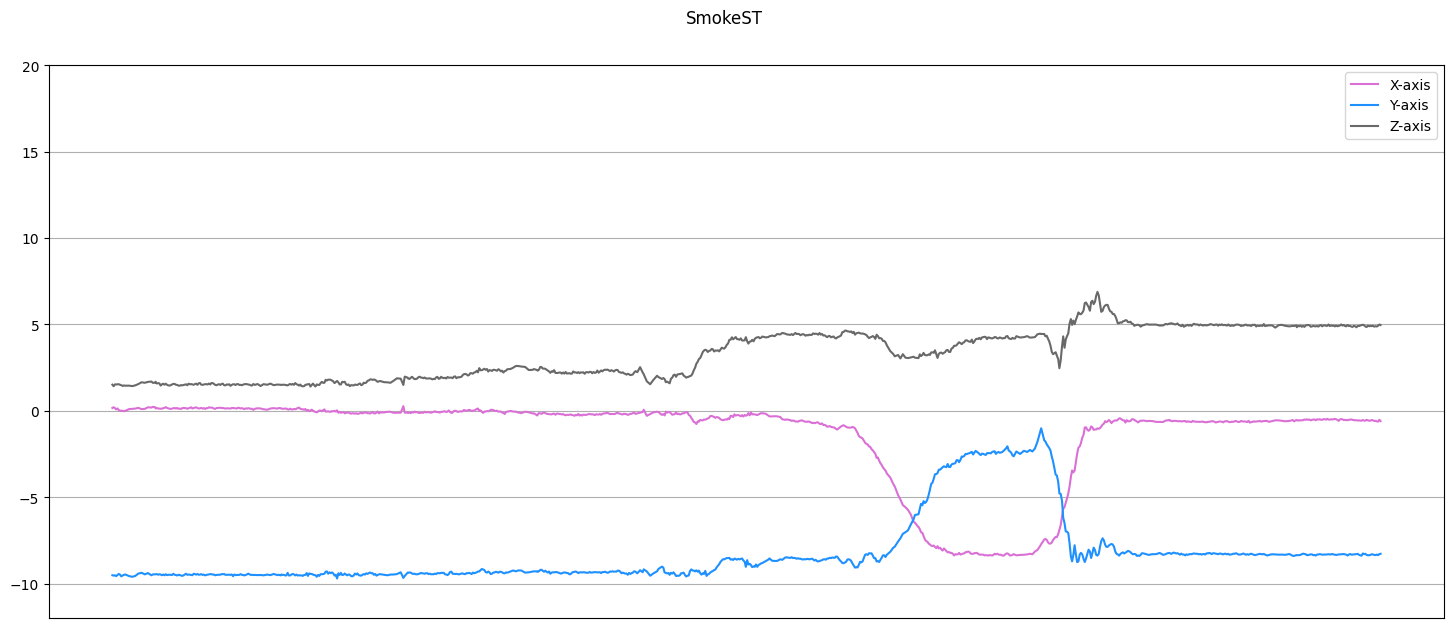

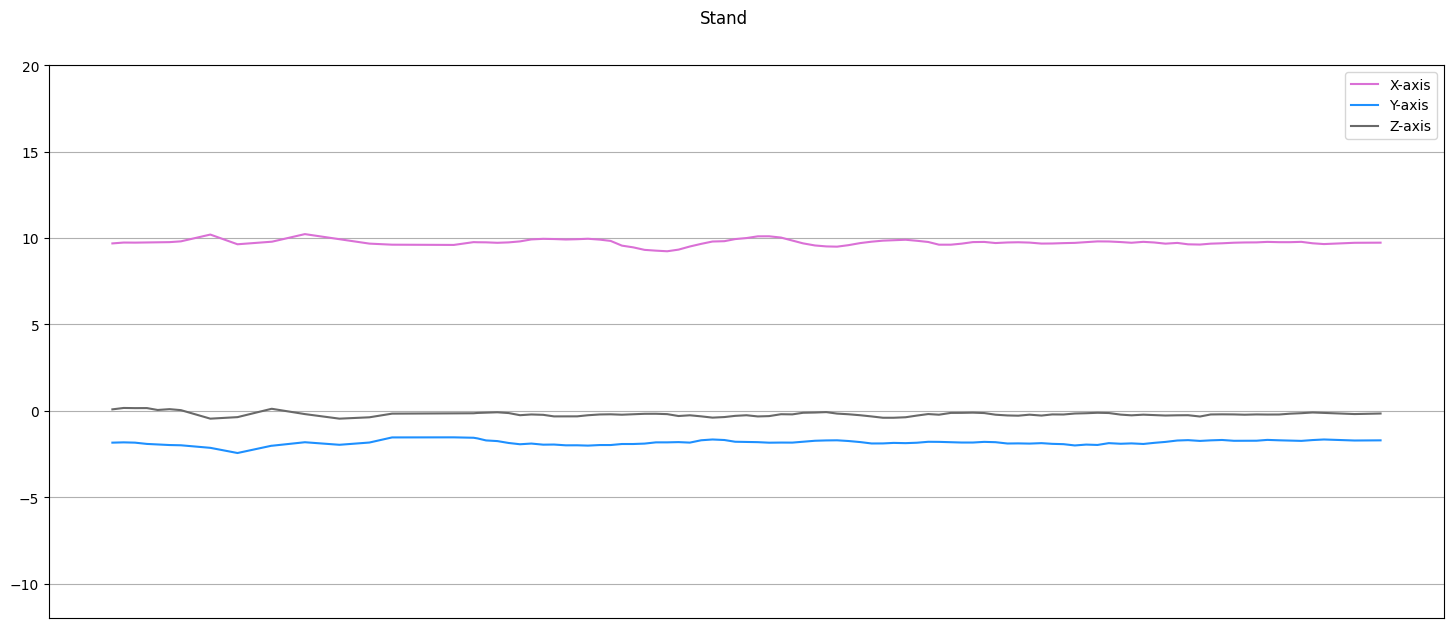

Participant8_Data.pickle


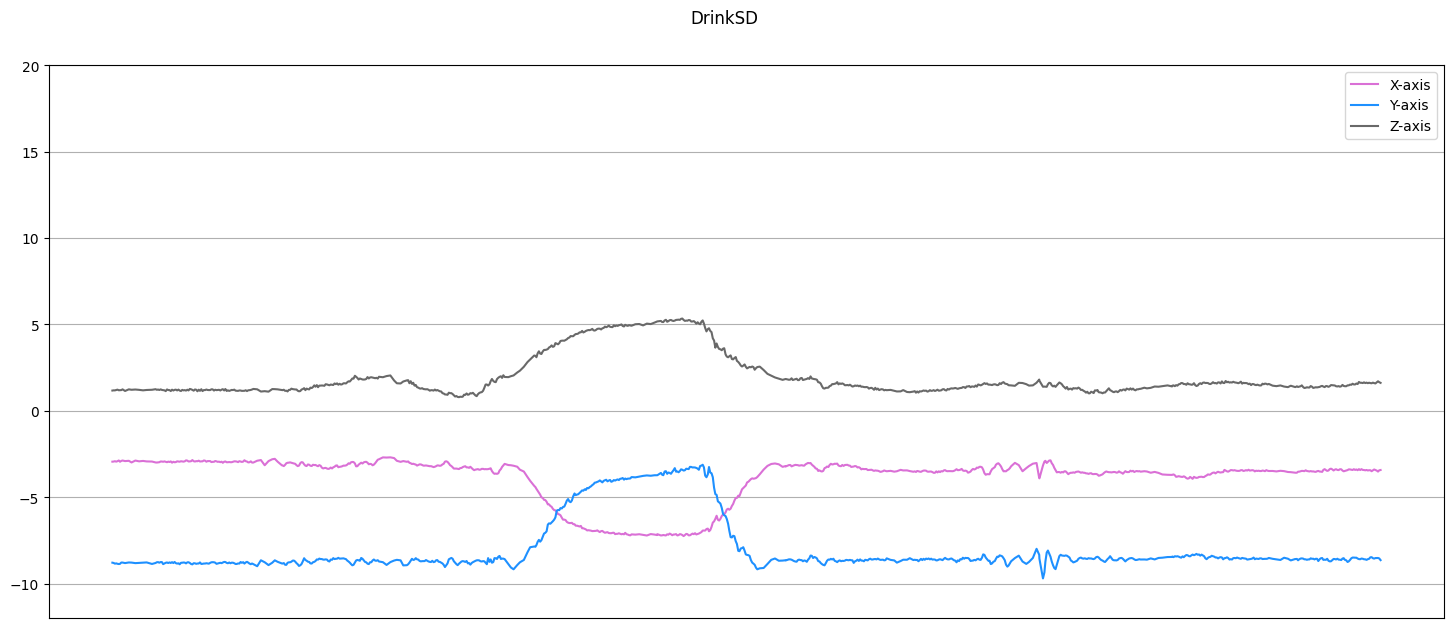

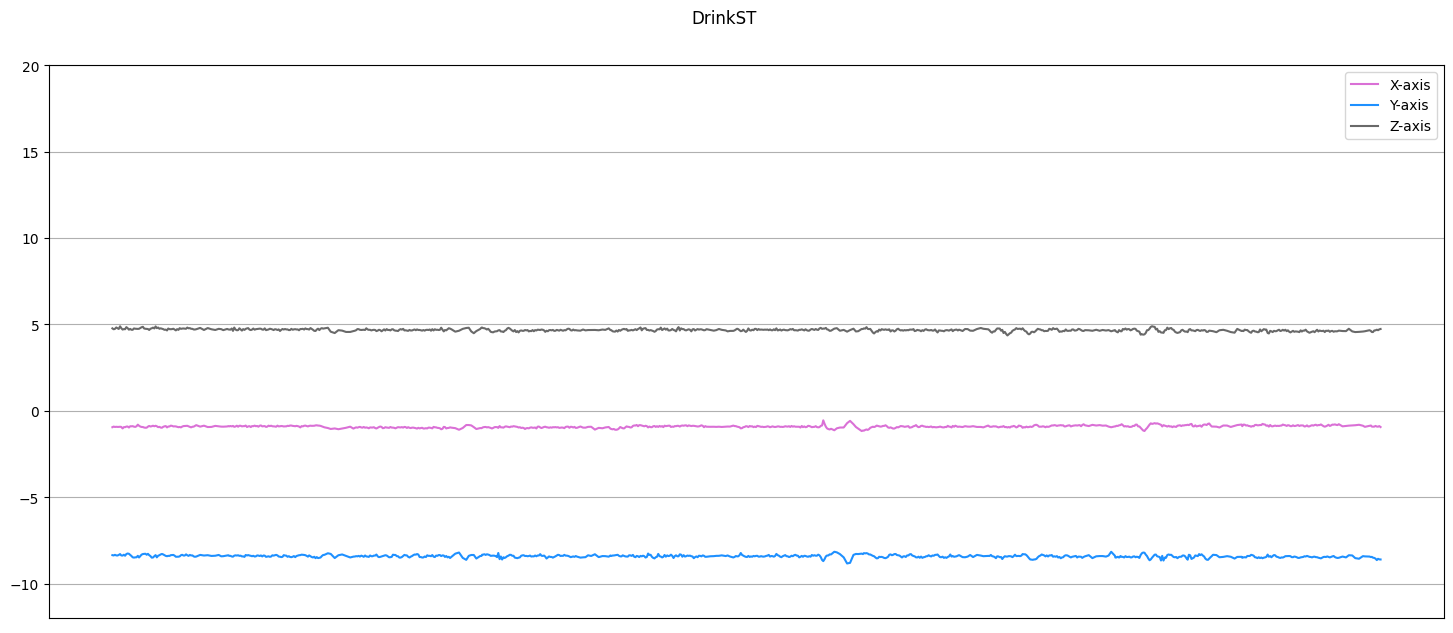

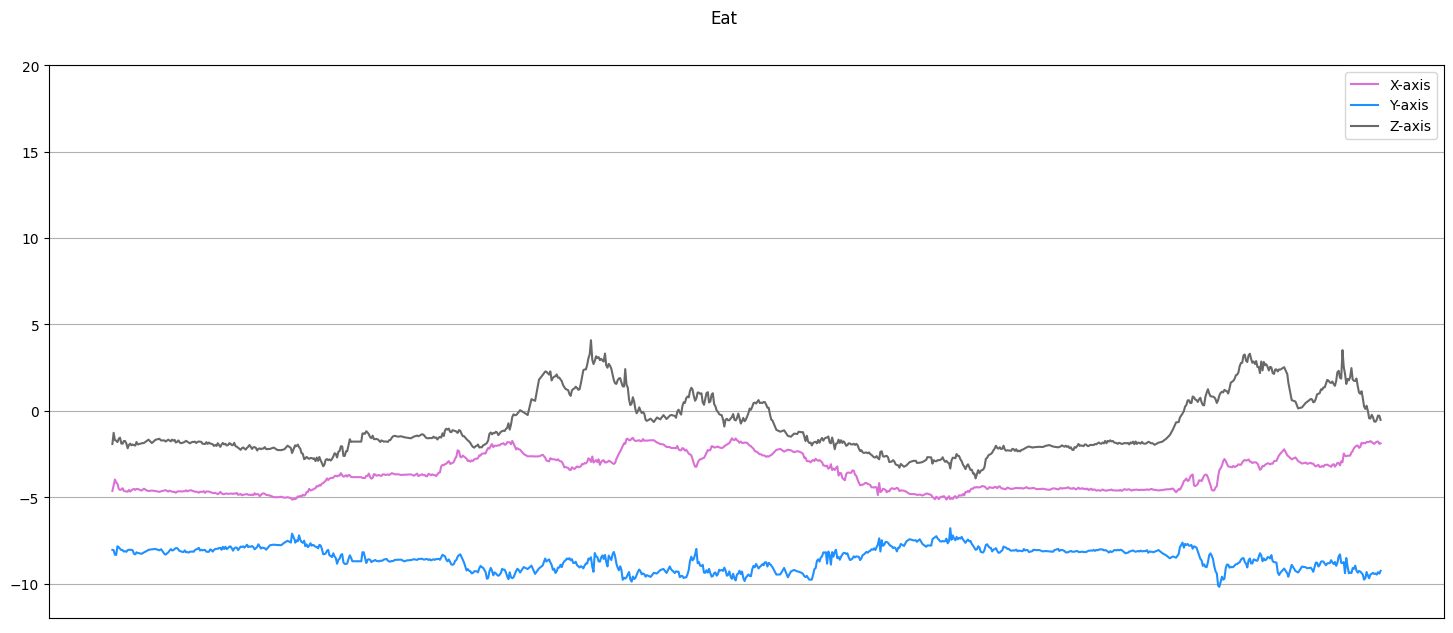

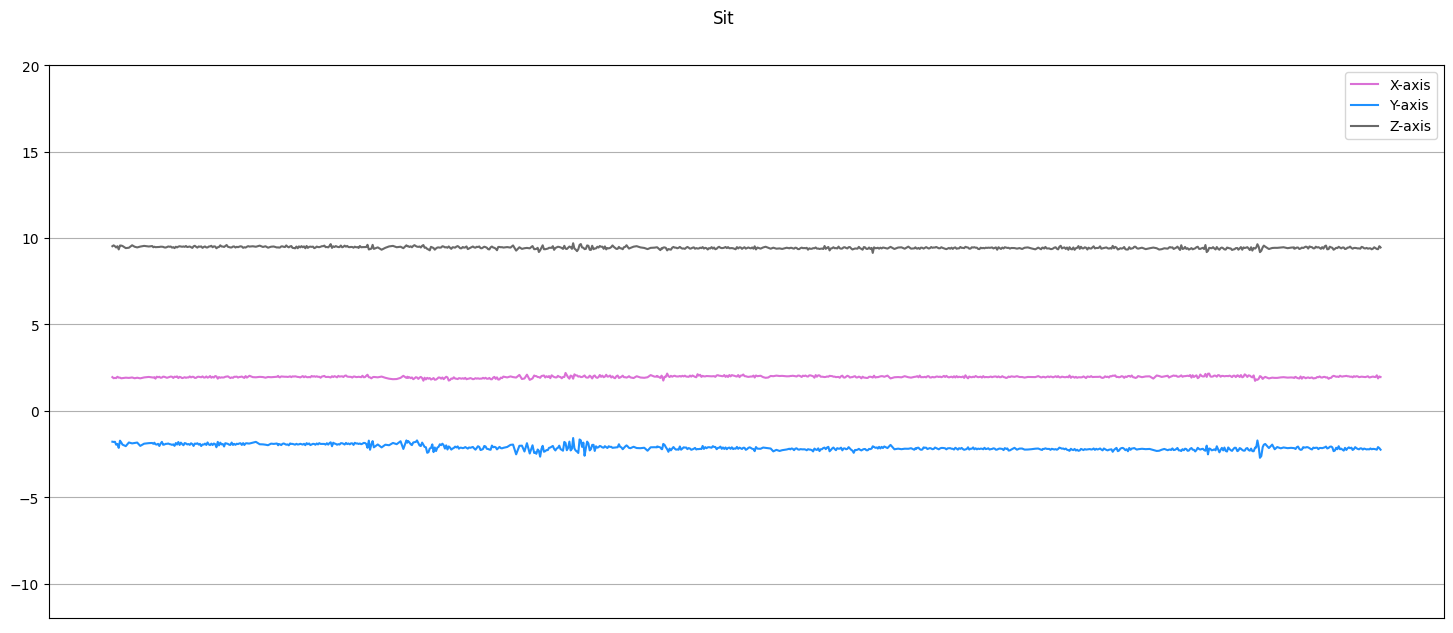

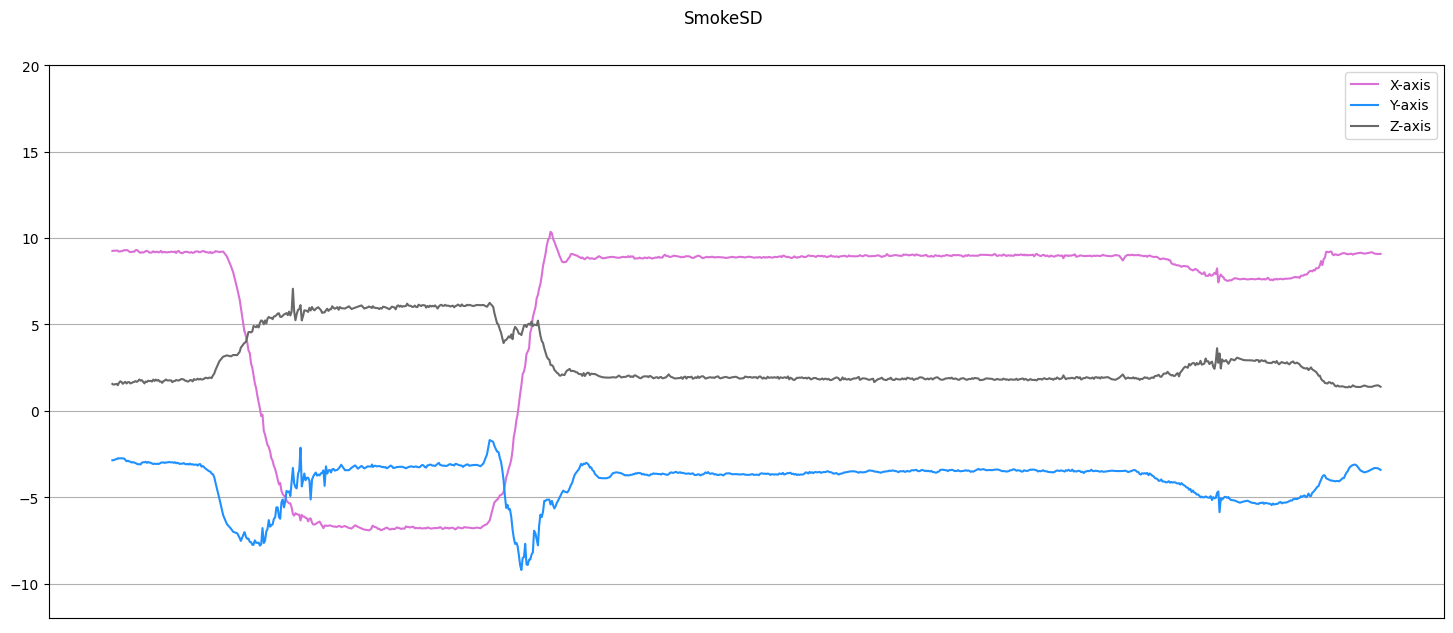

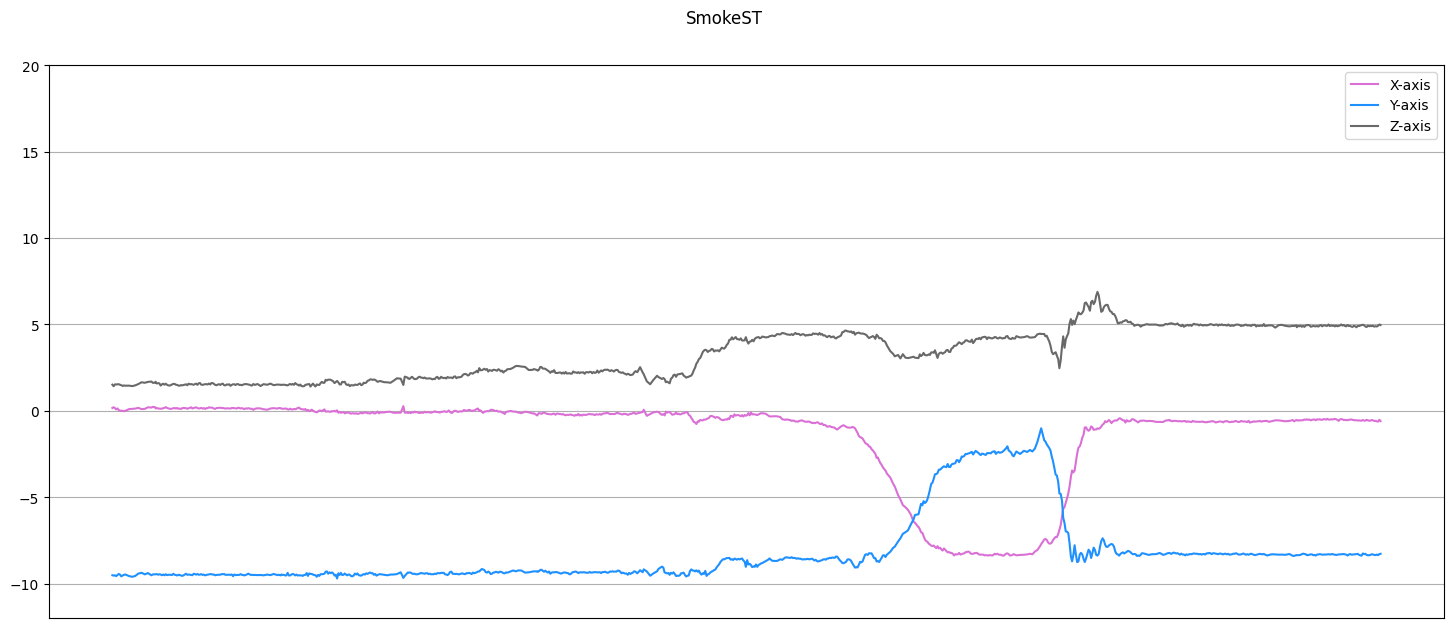

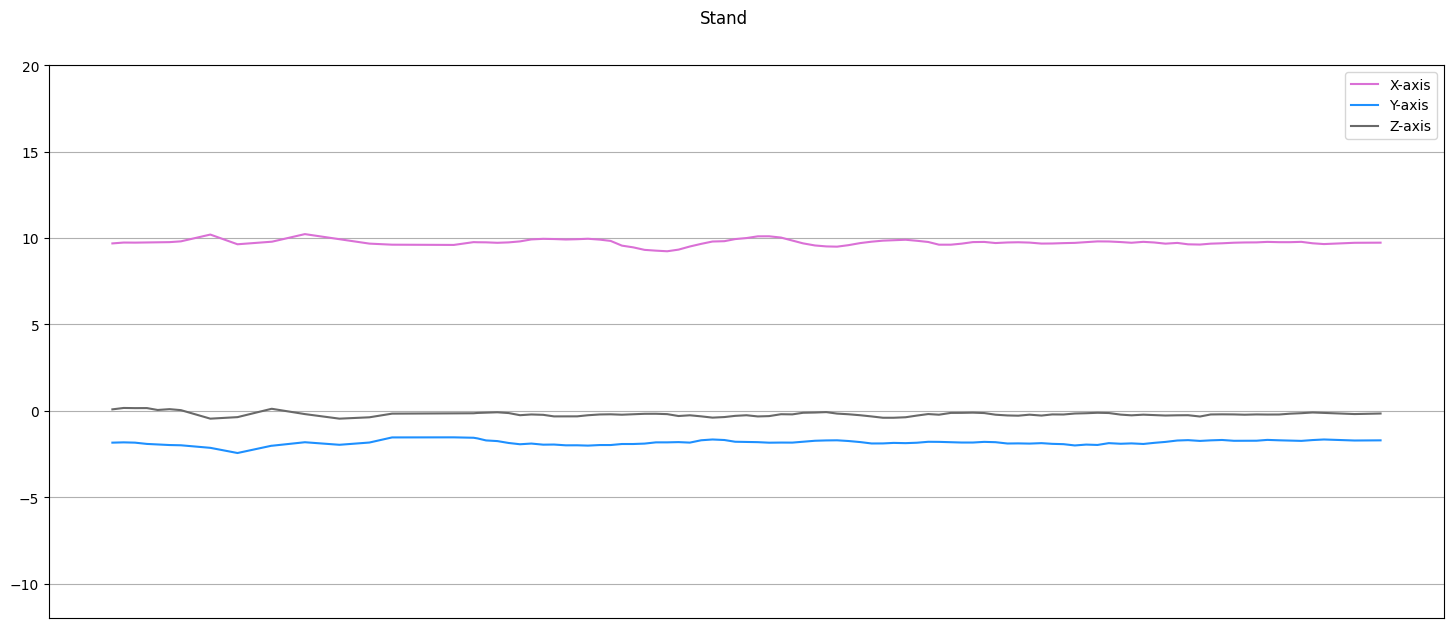

Participant9_Data.pickle


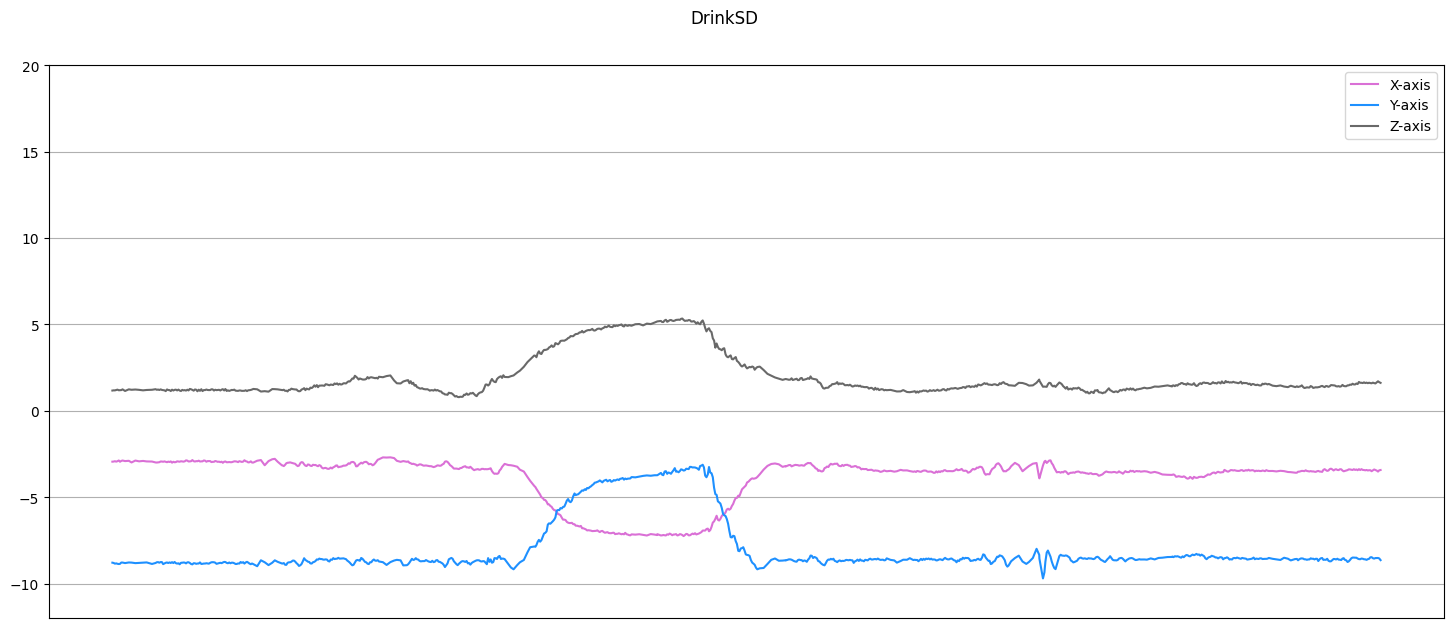

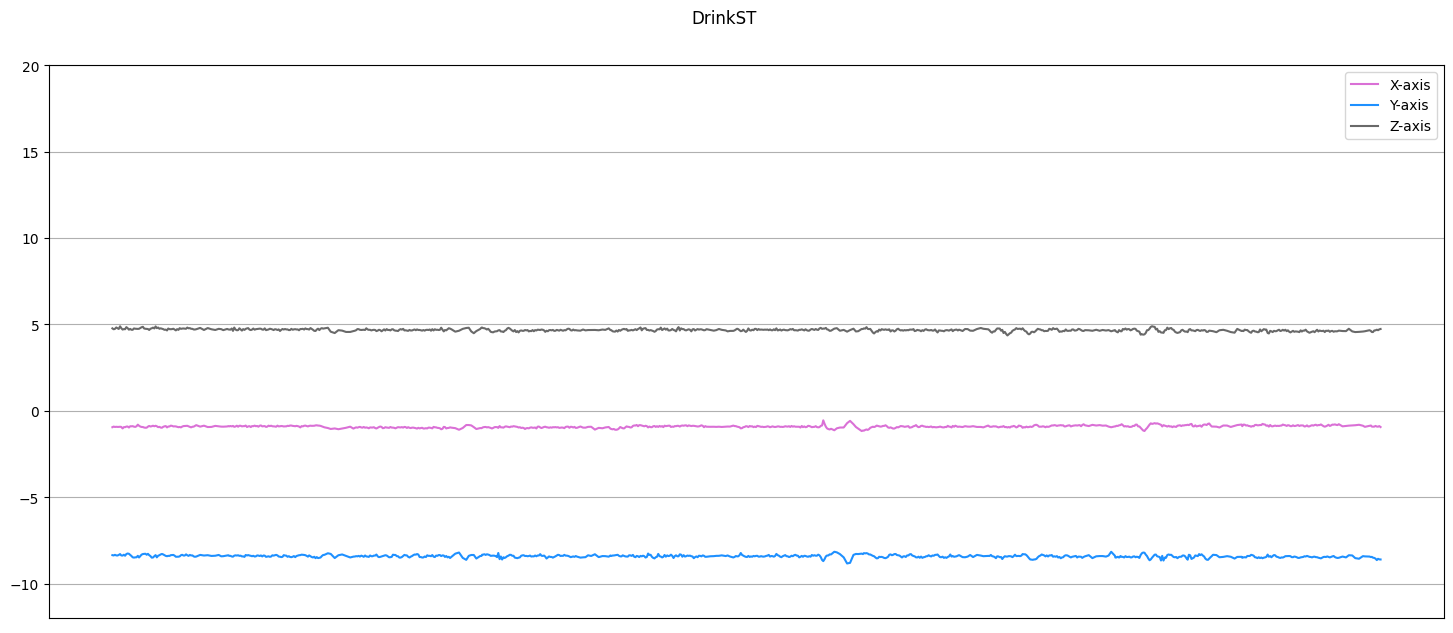

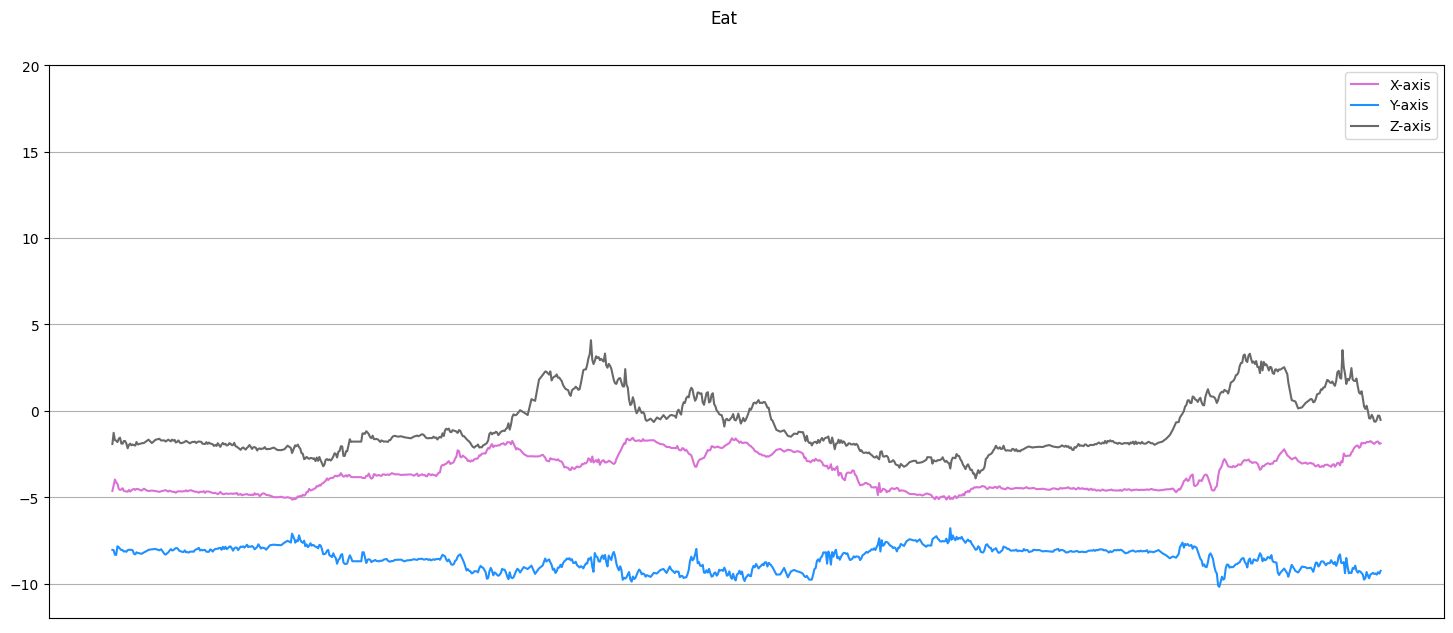

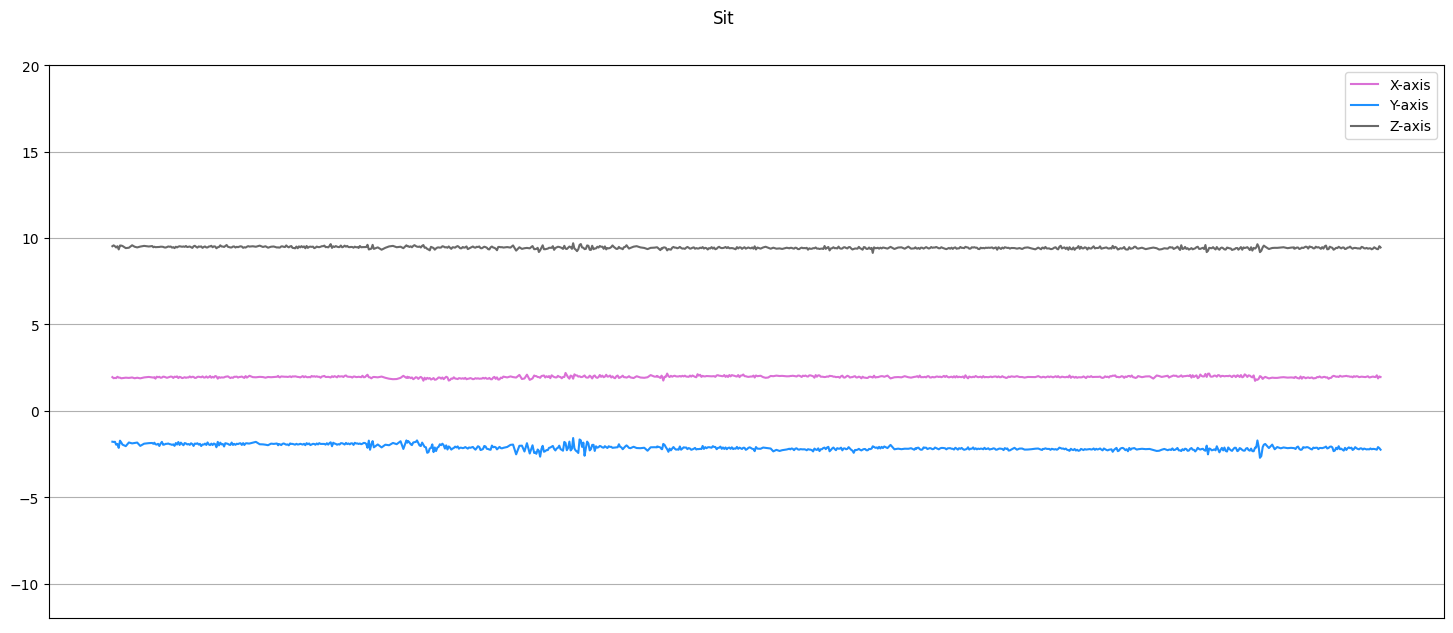

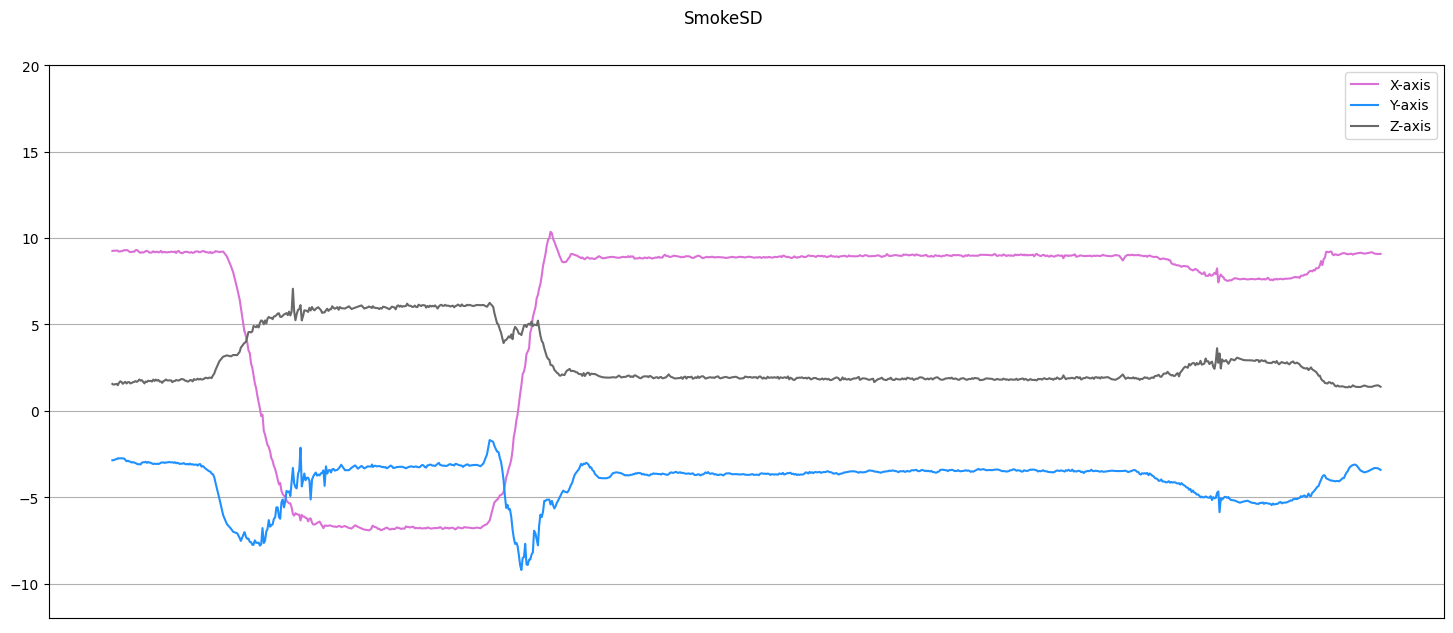

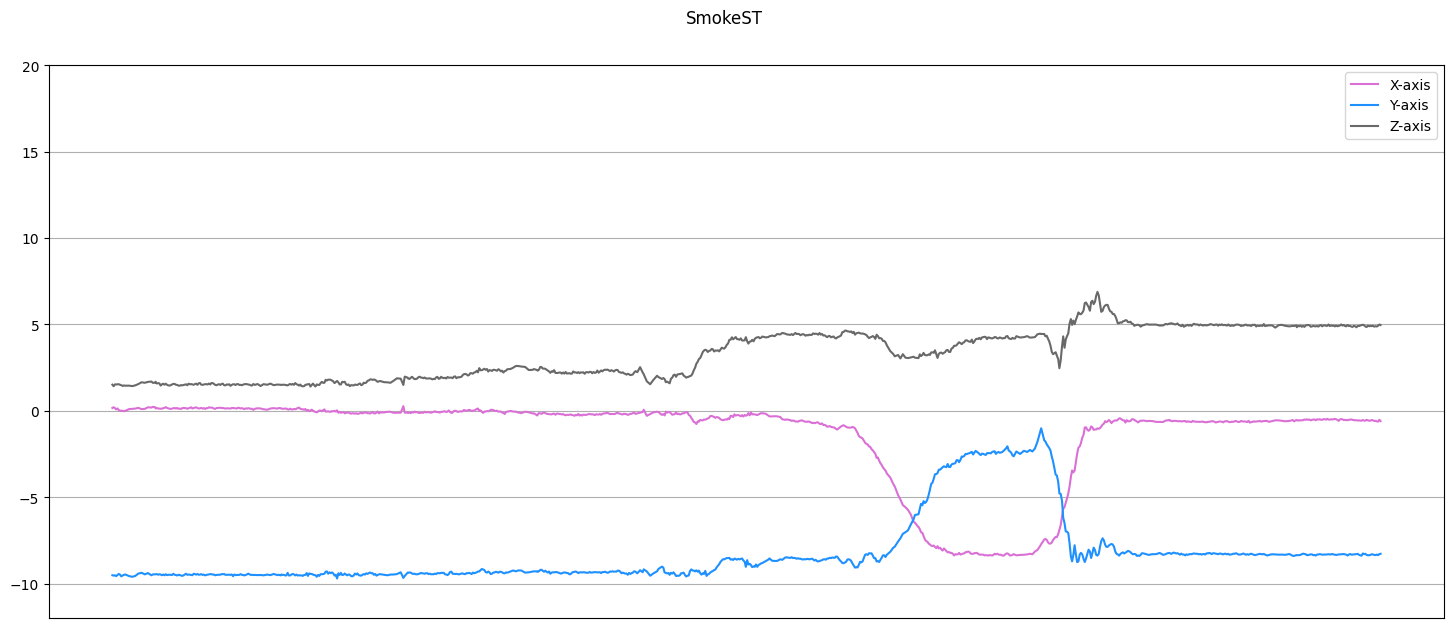

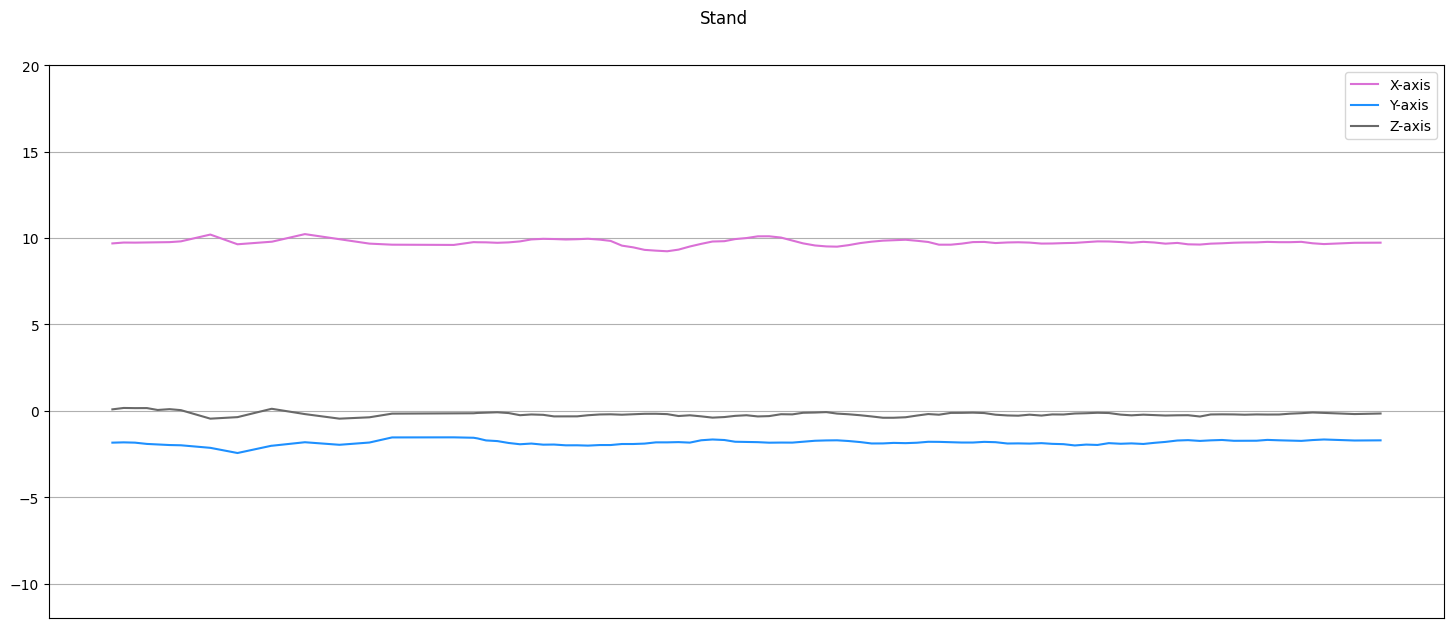

In [37]:
ts_field='datime_WD'  #cleaned up one, 
                      #otherwise sort will die on timestamp_WD of participant1 

def plot_activity(activity, data, fname):

    fig, ax = plt.subplots(figsize=(18, 7))
    plt.plot( data[ts_field], data['Accelerometer_x_WD'], color='orchid', linewidth=1.5, label="X-axis")
    plt.plot( data[ts_field], data['Accelerometer_y_WD'], color='dodgerblue', linewidth=1.5,  label="Y-axis")
    plt.plot( data[ts_field], data['Accelerometer_z_WD'], color='dimgrey', linewidth=1.5, label="Z-axis")
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top=0.90)
    plt.suptitle(activity)
    plt.legend()
    plt.ylim(-12 , 20)
    plt.grid(True)
    plt.xticks([])
    plt.show()

do_plot_activity=False
if do_plot_activity:
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
        # load raw from pickle    
        if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue

        skip_this_one=False
        for dude in ignore_dudes :
            if f_in.startswith(dude):
                print ("skipping {}".format(dude))
                skip_this_one=True
                break        
        if skip_this_one: continue        
        data = pd.read_pickle(os.path.join(pickles_dir, f_in)) 
        data=data.sort_values(by=ts_field, ignore_index=True)
        data=data2.reset_index(drop=True)
    
        print("{}".format(f_in))
        for activity in np.unique(data[categ_colname]):
          subset = data[data[categ_colname] == activity][2000:3000]
          plot_activity(activity, subset, f_in)   

In [ ]:
#someone should revite will cell ! it's so slow...!

ts_field='datime_WD'  #cleaned up one, 
                      #otherwise sort will die on timestamp_WD of participant1 

f_ins=[]
for f_in in os.listdir(pickles_dir):     
    # load raw from pickle    
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
     
    skip_this_one=False
    for dude in ignore_dudes :
        if f_in.startswith(dude):
            print ("skipping {}".format(dude))
            skip_this_one=True
            break        
    if skip_this_one: continue        
    f_ins.append(f_in)

n_files=len(f_ins)
if n_files == 0 :
    raise("no pickles to process!..")


print("making windows for {}".format(id_str))

X_act_data={} #final dict (par participant) with dicts {acivity:[list of frames of res_y duration]}

n_participant=0
participants=[]

for f_in in f_ins:     
    
    n_files-=1
    print("prcessing {}, {} more left".format(f_in, n_files))

    data = pd.read_pickle(os.path.join(pickles_dir, f_in)) 
       
    act_types_in_file=np.sort(data[categ_colname].unique())
    
    if len(act_types_in_file) != n_act_types :
        
       if n_act_types > len(act_types_in_file) :         
         diff_acts=list(set(act_types) - set(act_types_in_file))
       else:
         diff_acts=list(set(act_types_in_file) - set(act_types)) 
       
       print("achtung, file {} has new or missing activities...".format(f_in, ", ".join(diff_acts))) 
   
    # make windows sets from raw...
    
    X_act_participant={} #will be appended to X_act_data after the loop is done...
    
    max_count = int(len(data)/tot_frame_len)
    if overlap : max_count+=max_count
        
    print("expecting approx {} images in total...".format(max_count))
    
    pbar = IntProgress(min=0, max=max_count) 
    display(pbar) 
        
    for act_type in act_types :
      data_cursor = data[(data[categ_colname] == act_type)].copy() 
      data_act_type_len=len(data_cursor)-tot_frame_len
      X_act_participant[act_type]=[]
    
      if data_act_type_len < tot_frame_len : 
        print("start skipping {} cur not enugh for at least 1 frame...".format(act_type))
        continue
      
      data2=data_cursor.sort_values(by=ts_field, ignore_index=True)
      data_cursor=data2.reset_index(drop=True)
    
      if drop_dups: 
        #report first
        df=data_cursor.copy()
        duplicateRows = df[df.duplicated()]
        ndups=len(duplicateRows)
        pcntage=int( 100*float(ndups)/float(len(df)) ) 
        print("\n{} ({}) dups in act type {}".format(ndups, pcntage, act_type))
        
        data_cursor.drop_duplicates(inplace=True)
        duplicateRows = data_cursor[data_cursor.duplicated()]
        ndups=len(duplicateRows)
        print("ndups afer cleaning {}\n".format(ndups))
        
        data_act_type_len=len(data_cursor)-tot_frame_len
        
      max_count_act = int( len(data_cursor)/tot_frame_len )
      if overlap : max_count_act += max_count_act
      print("expecting approx {} {} windows in total...".format(act_type, max_count_act))     
    
      nth_frame=0   
      overlap_shift=0
     
      _overlap=overlap
    
      while True:  
        cur_pos=nth_frame*tot_frame_len
        if cur_pos > data_act_type_len :  
          if not _overlap : break  
            
          #on overlap make 2nd pass shiting init cursor pos (i.e. beg of dataframe) 1/2 window len
          cur_pos       = 0
          nth_frame     = 0
          overlap_shift = overlap_len
          _overlap      = False
          print("overlap pass...")
            
        #====== start sliding window... 
        
        beg_row=nth_frame*tot_frame_len+overlap_shift
        end_row=beg_row+tot_frame_len
        
        #need chk it for overlap
        if overlap_shift !=0 and end_row >= data_act_type_len : break
        
        data_tmp=data_cursor[beg_row:end_row] 

        #fill frame from data_tmp...
        raw_data = [] 
        _cur_pos = 0
        
        for nth_sec in range(0, win_len):
          if _cur_pos == tot_frame_len :  break           
          for nrow in range(0, sampling):
             _cur_pos=sampling*nth_sec+nrow
             if _cur_pos == tot_frame_len : break        
             try:
               row=data_tmp.iloc[_cur_pos] 
             except Expetion as _ex:
               raise("error {}".format(str(_ex)))
                
             for fld in sensors:
                raw_data.append(row[fld] * sensors_weights[fld])

        X_act_participant[act_type].append(np.array(raw_data))
        nth_frame+=1

        pbar.value += 1   
        if pbar.value % 20 == 0:
           print("{} dataframes of {}".format(20, act_type))

      print("processed {} frames of {}".format(nth_frame, act_type))
    
    X_act_data[n_participant]=X_act_participant 
    participants.append(f_in)
    
    print("done with participant {}\n".format(n_participant))
    n_participant=n_participant+1

print("all done..")

skipping Participant10
making windows for 6sensors_30_win_with_overlap_no_dups_sensor_adjusted
prcessing Participant11_Data.pickle, 9 more left
expecting approx 522 images in total...


IntProgress(value=0, max=522)


1 (0) dups in act type DrinkSD
ndups afer cleaning 0

expecting approx DrinkSD 74 windows in total...
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 35 frames of DrinkSD

78 (0) dups in act type DrinkST
ndups afer cleaning 0

expecting approx DrinkST 74 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 35 frames of DrinkST

15 (0) dups in act type Eat
ndups afer cleaning 0

expecting approx Eat 74 windows in total...
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
processed 35 frames of Eat

28 (0) dups in act type Sit
ndups afer cleaning 0

expecting approx Sit 74 windows in total...
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
processed 35 frames of Sit

79 (0) dups in act type SmokeSD
ndups afer cleaning 0

expecting approx SmokeSD 74 windows in tota

IntProgress(value=0, max=1204)


181 (0) dups in act type DrinkSD
ndups afer cleaning 0

expecting approx DrinkSD 172 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 84 frames of DrinkSD

79 (0) dups in act type DrinkST
ndups afer cleaning 0

expecting approx DrinkST 172 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 84 frames of DrinkST

134 (0) dups in act type Eat
ndups afer cleaning 0

expecting approx Eat 172 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 datafr

IntProgress(value=0, max=1318)


170 (0) dups in act type DrinkSD
ndups afer cleaning 0

expecting approx DrinkSD 188 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 92 frames of DrinkSD

62 (0) dups in act type DrinkST
ndups afer cleaning 0

expecting approx DrinkST 188 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 92 frames of DrinkST

366 (0) dups in act type Eat
ndups afer cleaning 0

expecting approx Eat 188 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 da

IntProgress(value=0, max=1352)


139 (0) dups in act type DrinkSD
ndups afer cleaning 0

expecting approx DrinkSD 192 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 94 frames of DrinkSD

86 (0) dups in act type DrinkST
ndups afer cleaning 0

expecting approx DrinkST 192 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 94 frames of DrinkST

314 (0) dups in act type Eat
ndups afer cleaning 0

expecting approx Eat 192 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
2

IntProgress(value=0, max=1038)


84 (0) dups in act type DrinkSD
ndups afer cleaning 0

expecting approx DrinkSD 148 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 72 frames of DrinkSD

183 (0) dups in act type DrinkST
ndups afer cleaning 0

expecting approx DrinkST 148 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 72 frames of DrinkST

147 (0) dups in act type Eat
ndups afer cleaning 0

expecting approx Eat 148 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
processed 72 frames of Eat

55 (0) dups in act type Sit
ndups afer cleaning 0

expec

In [40]:
print("n parts: {}, n categs: {}".format(len(X_act_data), len(X_act_data[0])))

n parts: 10, n categs: 7


In [5]:
#pip install pq-tool
#os.environ['x_dir_to_list'] = local_full_path+"/"+x_dir
#!cd $x_dir_to_list && ls -l && for x in *; do pq keys $x; done

total 1121824
-rwxr-xr-x 1 root root 148237464 Dec  5 12:19 x_3sensors_win20_secs.dump
-rwxr-xr-x 1 root root 289606668 Dec  4 22:32 x_3sensors_win30_with_overlap_secs.dump
-rwxr-xr-x 1 root root 146248554 Dec  5 14:51 x_3sensors_win60_secs.dump
-rwxr-xr-x 1 root root 564649908 Dec  4 20:09 x_6sensors_win60_with_overlap_secs.dump
[   'sampling',
    'window',
    'overlap',
    'overlap_len',
    'sensors',
    'sensors_weights',
    'participants',
    'x']
[   'sampling',
    'window',
    'overlap',
    'overlap_len',
    'sensors',
    'sensors_weights',
    'participants',
    'x']
[   'sampling',
    'window',
    'overlap',
    'overlap_len',
    'sensors',
    'sensors_weights',
    'participants',
    'x']
[   'sampling',
    'window',
    'overlap',
    'overlap_len',
    'sensors',
    'sensors_weights',
    'participants',
    'x']


In [41]:
save_2picke = True 
load_from_pickle=False

x_obj_fname=x_dir + "/" + "x_" + id_str + "_secs.dump"

if save_2picke : 
  x_to_save={"sampling"   : sampling,  "window"          : win_len,  
             "overlap"    : overlap,   "overlap_len"     : overlap_len,
             "sensors"    : sensors,   "sensors_weights" : sensors_weights, 
             "drop_dups"  : drop_dups,
             "" : act_types, "participants" : participants,               
             "x": X_act_data }
  
  X_act_data_file = open(x_obj_fname, 'wb')
  pickle.dump(x_to_save, X_act_data_file)
  X_act_data_file.close()
  print("saved  x to {}".format(x_obj_fname))

if load_from_pickle :
  if os.path.exists(x_obj_fname) :
    try:
       X_act_data_file = open(x_obj_fname, 'rb')
       x_to_save = pickle.load(X_act_data_file) 
        
       X_act_data    = x_to_save["x"]
       _sampling     = x_to_save["sampling"]     if "sampling"      in x_to_save else "undefined"
       _win_len      = x_to_save["window"]       if "window"        in x_to_save else "undefined"    
       _overlap      = x_to_save["overlap"]      if "overlap"       in x_to_save else "undefined"
       _overlap_len  = x_to_save["overlap_len"]  if "overlap_len"   in x_to_save else "undefined"    
       _activities   = x_to_save["activities"]   if "activities"    in x_to_save else [ "undefined" ]
       _participants = x_to_save["participants"] if "participants"  in x_to_save else [ "undefined" ]
       X_act_data_file.close()
    
       print("loaded x of len {} ok".format(len(X_act_data)))
       print("sampling: {}, win_len: {}, overlap {}, overlap_len {}".format(_sampling, _win_len, _overlap, _overlap_len))
       print("participants: {}".format(", ".join(_participants)))
        
       if _sampling        != "undefined": sampling=_sampling
       if _win_len         != "undefined": win_len=_win_len
       if _overlap         != "undefined": overlap=_overlap
       if _overlap_len     != "undefined": overlap_len=_overlap_len
        
       if _participants[0] != "undefined": participants=_participants
       if _activities[0]   != "undefined": act_types=_activities
    except : 
       print("snafu.. on loading from {}".format(x_obj_fname))
    
  else:
     print("no such file: {}".format(x_obj_fname))

saved  x to UT_Smoking_Data_x/x_1sensors_30_win_with_overlap_no_dups_sensor_adjusted_secs.dump
